# HW Overview

Please complete all core assignment tasks. For 50% bonus points please complete the optional stretech assignment tasks that will involve more theory and programming.

The goals of this HW include the following:
* master pipelines for regression prediction problems
  * Exploratory data analysis
  * Date preprocessing
    * Data standardization
    * Deal with missing data
    * Dealing with categorical input features via, say, OHE 
  * Linear regression modeling (regularized or not)
  * Various performance metrics
  
  
Please consult Canvas for the grading rubric (check Module 05 -> HW 05).


# Preparation

Import required libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Set style for plotting

In [2]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

Fix random seed for reproducibility

In [3]:
np.random.seed(42)

# Boston House Prices

We have seen this dataset previously while working with KNN Regression. In this notebook, we're going to build a different regression model for predicting house prices in thousands of dollars given factors such as crime rate in neighborhood, number of schools, % lower status of the population, etc.

## Reading data

Boston dataset is extremely common in machine learning experiments thus it is embedded in sklearn.

In [4]:
boston = load_boston()

Detailed description of dataset and features

In [5]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

Create pandas dataframe with objects in rows and features in columns

In [6]:
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

In [7]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


## Exploratory data analysis (EDA)

All features are numerical, but note that some features are categorical (e.g., CHAS) while others are continuous.

In [8]:
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


Let's also take a look into correlation matrix of features

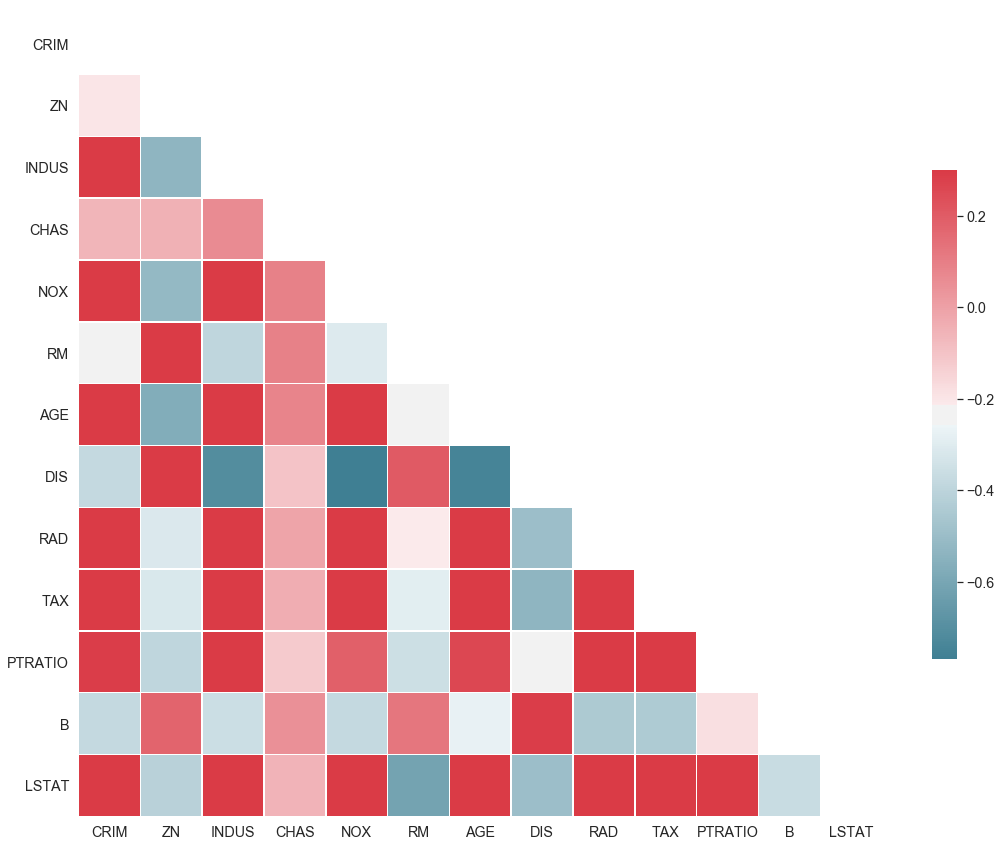

In [9]:
# compute the correlation matrix
corr = X.corr()

# generate a mask for the lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

## Preprocessing

### Splitting the data (train/test)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

There are lots of feature. Let's visualize two of them across the train and test data. 

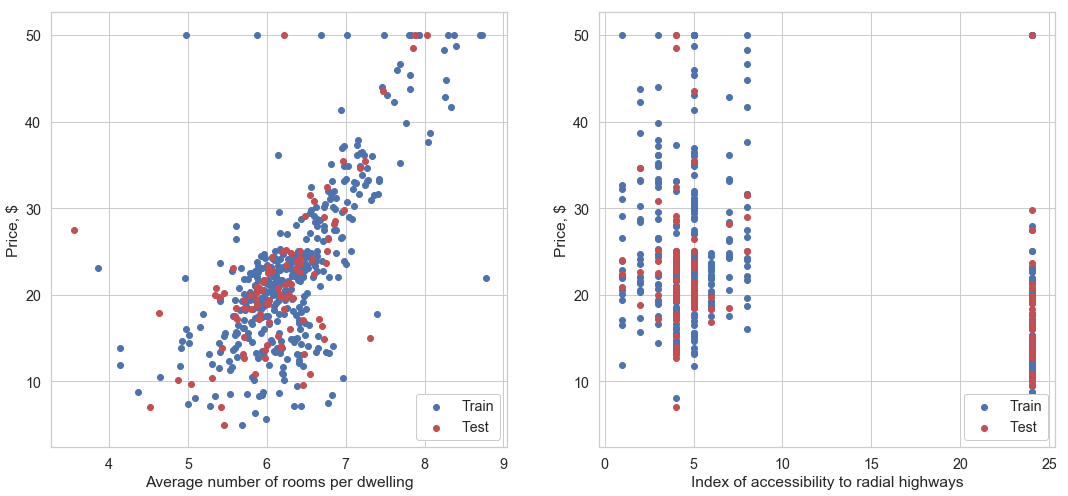

In [11]:
plt.figure(figsize=(18, 8))
plt.subplot(121)
plt.scatter(X_train.RM, y_train, label="Train")
plt.scatter(X_test.RM, y_test, c="r", label="Test")
plt.xlabel("Average number of rooms per dwelling")
plt.ylabel("Price, $")
plt.legend(loc="lower right", frameon=True)
plt.subplot(122)
plt.scatter(X_train.RAD, y_train, label="Train")
plt.scatter(X_test.RAD, y_test, c="r", label="Test")
plt.xlabel("Index of accessibility to radial highways")
plt.ylabel("Price, $")
plt.legend(loc="lower right");

### Scaling

Normalize data in the range $(0,1)$ to make our data insensitive to the scale of features.

In [12]:
scaler = MinMaxScaler()

Note that we're going to learn normalization constants only on training set. That's done because the assumption is that test set is unreachable during training.

In [13]:
X_train = scaler.fit_transform(X_train)

Transform test set with the same constants

In [14]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102 entries, 173 to 75
Data columns (total 13 columns):
CRIM       102 non-null float64
ZN         102 non-null float64
INDUS      102 non-null float64
CHAS       102 non-null float64
NOX        102 non-null float64
RM         102 non-null float64
AGE        102 non-null float64
DIS        102 non-null float64
RAD        102 non-null float64
TAX        102 non-null float64
PTRATIO    102 non-null float64
B          102 non-null float64
LSTAT      102 non-null float64
dtypes: float64(13)
memory usage: 11.2 KB


In [15]:
X_test = scaler.transform(X_test)

In [16]:
type(X)

pandas.core.frame.DataFrame

In [17]:
#y.hist()
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


/Users/jgisrael/anaconda3/envs/i526/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


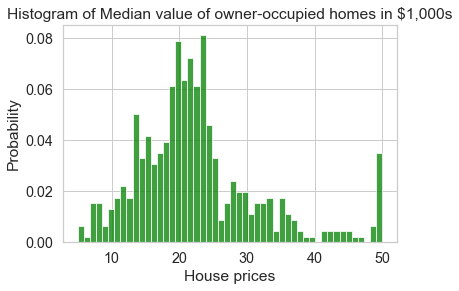

In [18]:

# the histogram of the data
n, bins, patches = plt.hist(y, 50, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
#l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('House prices')
plt.ylabel('Probability')
plt.title(r'Histogram of Median value of owner-occupied homes in $1,000s')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()

### Plot distributions of each input variable

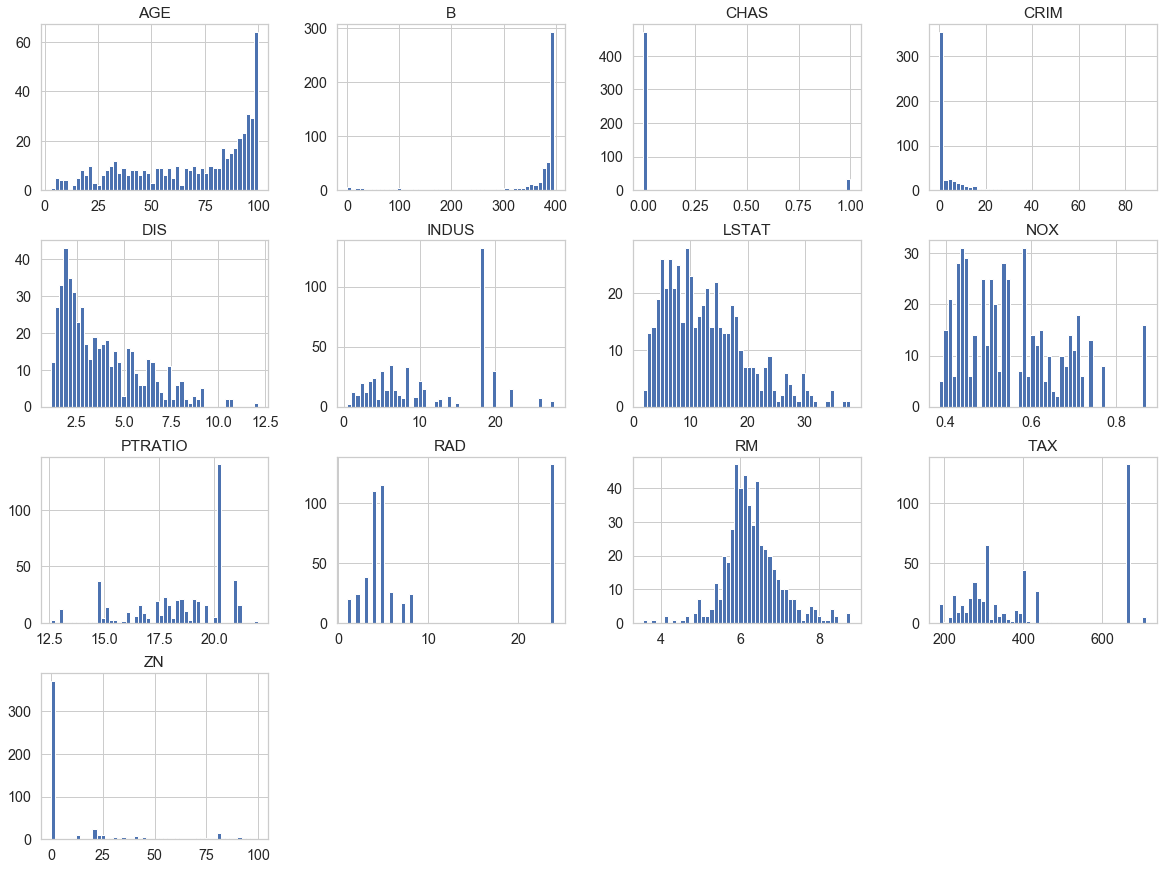

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
X.hist(bins=50, figsize=(20,15))
plt.show()

# Sklearn Linear Regression

## Fitting

Here we use very simple Linear Regression model. Scikit-learn uses the closed-form solition for Linear Regression problem thus it gives very good results.

In [20]:
model_sk = LinearRegression()

Fitting model on prepared data

In [21]:
model_sk.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Evaluation

Let's see what features are significant for the model. Largest coefficients will have greatest impact on the model.

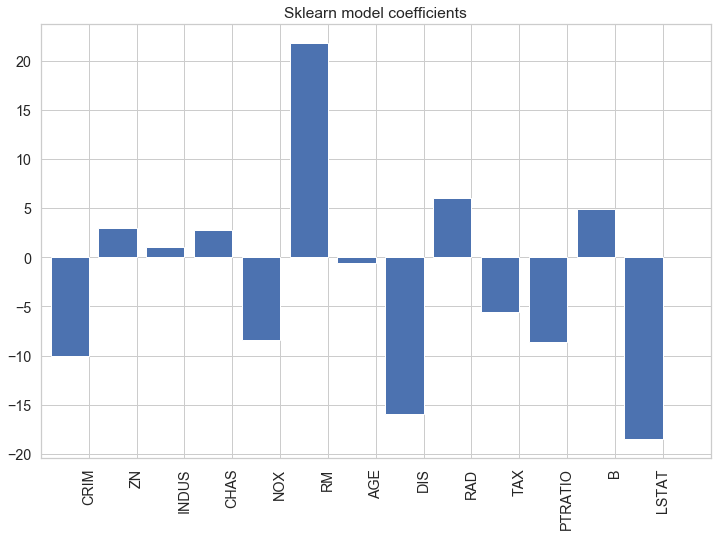

In [22]:
plt.figure(figsize=(12, 8))
plt.bar(np.arange(model_sk.coef_.shape[0]) - 0.4, model_sk.coef_)
plt.xticks(np.arange(model_sk.coef_.shape[0]), X.columns, rotation='vertical')
plt.xlim([-1, model_sk.coef_.shape[0]])
plt.title("Sklearn model coefficients");

Predicting both train and test sets to evaluate model

In [23]:
preds_test = model_sk.predict(X_test)
preds_train = model_sk.predict(X_train)

###  Mean absolute percentage error (MAPE)
There is no MAPE implementation in sklearn (because this metric is undefined when real value is zero). Below one can find my own implementation.

The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method in statistics, for example in trend estimation. It usually expresses accuracy as a percentage, and is defined by the formula:

$${\displaystyle {\mbox{M}}={\frac {100\%}{n}}\sum _{t=1}^{n}\left|{\frac {A_{t}-F_{t}}{A_{t}}}\right|,} $$
where At is the actual value and Ft is the forecast value.

The difference between At and Ft is divided by the Actual value At again. The absolute value in this calculation is summed for every forecasted point in time and divided by the number of fitted points n. Multiplying by 100% makes it a percentage error.

Although the concept of MAPE sounds very simple and convincing, it has major drawbacks in practical application 

It cannot be used if there are zero values (which sometimes happens for example in demand data) because there would be a division by zero.
For forecasts which are too low the percentage error cannot exceed 100%, but for forecasts which are too high there is no upper limit to the percentage error.
When MAPE is used to compare the accuracy of prediction methods it is biased in that it will systematically select a method whose forecasts are too low. This little-known but serious issue can be overcome by using an accuracy measure based on the ratio of the predicted to actual value (called the Accuracy Ratio), this approach leads to superior statistical properties and leads to predictions which can be interpreted in terms of the geometric mean.

For more details on MAPE please see [here](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)

In [24]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """
    Use of this metric is not recommended because can cause division by zero
    See other regression metrics on sklearn docs:
      http://scikit-learn.org/stable/modules/classes.html#regression-metrics
    Use like any other metric
    >>> y_true = [3, -0.5, 2, 7]; y_pred = [2.5, -0.3, 2, 8]
    >>> mean_absolute_percentage_error(y_true, y_pred)
    Out[]: 24.791666666666668
    """

    return np.mean(np.abs((y_true.ravel() - y_pred.ravel()) / y_true.ravel())) * 100

Let's evaluate our model according to three different metrics:
* MAE (Mean Absolute Error)
* RMSE (Root Mean Squared Error)
* MAPE (Mean Absolute Percentage Error)

In [25]:
metrics = [mean_absolute_error, 
           lambda y_true, y_pred: mean_squared_error(y_true, y_pred) ** 0.5, 
           mean_absolute_percentage_error]
metrics_names = ["MAE", 
                 "RMSE", 
                 "MAPE"]

Also we want to check quality on both train and test sets

In [26]:
samples = [(X_train, y_train), 
           (X_test, y_test)]
models_names = ["Sklearn"]

Let's do it in loop

In [27]:
models_names = ["Sklearn"]

In [28]:
def evaluate(models, metrics, samples, metrics_names, models_names):
    results = np.zeros((len(samples) * len(models), len(metrics)))
    samples_names = []
    for m in models_names:
        samples_names.extend([m + " Train", m + " Test"])
    for m_num, model in enumerate(models):
        for row, sample in enumerate(samples):
            for col, metric in enumerate(metrics):
                results[row + m_num * 2, col] = metric(sample[1], model.predict(sample[0]))
    results = pd.DataFrame(results, columns=metrics_names, index=samples_names)
    return results

In [29]:
models = [model_sk]

Evaluated metrics:

In [30]:
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585


It also interesting to take a look how the predicted points relate to real ones. All the points should lie on the black dotted line ($y=x$) assuming that our model is perfect

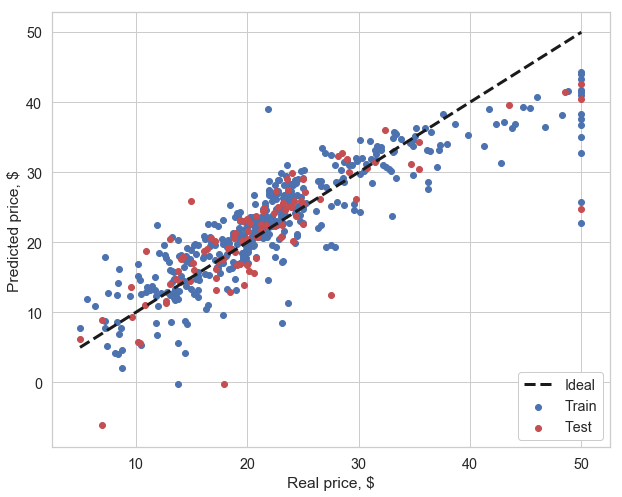

In [31]:
plt.figure(figsize=(10, 8))
plt.scatter(y_train, preds_train, label="Train")
plt.scatter(y_test, preds_test, c="r", label="Test")
plt.xlabel("Real price, $")
plt.ylabel("Predicted price, $")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3, label="Ideal")
plt.legend(loc="lower right");

## Cross-validation

The common method to evaluate the model is cross-validation. The idea behind it is to divide the whole set of objects into $k$ sections and then use one section as a test set and other $k-1$ as a train (repeat it with all the sections).

There is a special function for this in sklearn called $\text{KFold}$. It creates set of indices for cross-validation.

In [32]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

Next step is to do everything that we've done before in a loop:
* Split
* Scale
* Train
* Evaluate

And store the average value of the errors ($\text{res}$ variable)

In [33]:
cv_idx = list(cv.split(X_train, y_train))

In [34]:
res = None
for train_idx, test_idx in cv_idx:
    # split
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # scale
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    samples_cv = [(X_train, y_train), 
                  (X_test, y_test)]
    
    # fit
    model_sk_cv = LinearRegression().fit(samples_cv[0][0], samples_cv[0][1])
    
    # evaluate
    if res is None:
        res = evaluate([model_sk_cv], metrics, samples_cv, metrics_names, ["Sklearn CV"])
    else:
        res += evaluate([model_sk_cv], metrics, samples_cv, metrics_names, ["Sklearn CV"])
# take the average value across all folds
# show total residuals before taking average of 5 splits
res /= cv.n_splits

Here is the result of CV

In [35]:
res

,MAE,RMSE,MAPE
Sklearn CV Train,3.291561,4.732208,15.403616
Sklearn CV Test,3.470811,5.078768,16.195264


# Core Task:  Boston Regression via pipelines 

Using the Boston dataset from above (train, and blind test split). 

Core Assignment: Cross-validation with k=10 and stdev.<p>
Repeat the above experiment but change the code so that you can compute the standard deviation of the various metrics of interest (i.e., report MAE and stdMAE, RMSE and stdRMSE etc.) via cross-validation with k=10. 

In [36]:
def evaluate_std(models, metrics, samples, metrics_names, models_names):
    scores = np.zeros((len(samples) * len(models), len(metrics)))
    
    for m_num, model in enumerate(models):
        for row, sample in enumerate(samples):
            for col, metric in enumerate(metrics):
                scores[row + m_num * 2, col] = metric(sample[1], model.predict(sample[0]))
    return scores

In [37]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_idx = list(cv.split(X_train, y_train))

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
res = []
for train_idx, test_idx in cv_idx:
    # split
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # build pipeline
    pipe = Pipeline([('scalar', StandardScaler()),
                     ('linreg', LinearRegression())])
    
    samples_cv = [(X_train, y_train), 
                  (X_test, y_test)]
    
    # fit
    model_sk_cv = pipe.fit(samples_cv[0][0], samples_cv[0][1])
    
    # evaluate
    res.append(evaluate_std([model_sk_cv], metrics, samples_cv, metrics_names, ["Sklearn CV"]))

models_names = ["Sklearn"]
samples_names = []
for m in models_names:
    samples_names.extend([m + " Train", m + " Test"])
    
# extract results from KFold tests. e.g., 
# results[0] contains five MAE train scores
# results[3] contains five MAE test scores
results=[]
for s in range(len(samples_names)):
    for m in range(len(metrics_names)):
        calc = []
        for r in range(len(res)):
            calc.append(res[r][s][m])
        results.append(calc)

#build results table
metrics_names_std = []
for m in metrics_names:
    metrics_names_std.extend([m, m+"_STD"])
table = pd.DataFrame(index=samples_names, columns=metrics_names_std)

#compute stats and populate table
count=0
for s in range(len(samples_names)):
    for c in range(len(metrics_names)):
        table.iloc[s,c*2] = np.mean(results[count])
        table.iloc[s,(c*2)+1] = np.std(results[count])
        count+=1
table

,MAE,MAE_STD,RMSE,RMSE_STD,MAPE,MAPE_STD
Sklearn Train,2.3599,0.0396655,3.05718,0.0524327,9.86152,0.151298
Sklearn Test,2.50532,0.323854,3.22516,0.446225,10.4851,1.09284


# Core Task: Predicting Bike Sharing Demand (Kaggle competition)

The question provides a lot of background and sample code that you should review, run and extend to get familar with this problem and data set. Then you should tackle the tasks posed at the end of this question.

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world [as of 2014].

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.



Overview on the project:

* The objective is to predict the number of bikes that will be rented using the provided  data.
* You will use various python packages like numpy, pandas, seaborn and standardScaler are used to explore and do feature engineering on data.
* Finally you will build linear regression models and evalaute them using various metrics such as mean_squared_error
* Do a Kaggle submission and get a score for your submission. Please screenshot that and report it.
  * You won’t show up on the leaderboard, but you can still submit and get a score for your submission.



## Load Data

In [39]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
train=pd.read_csv('Kaggle-Bike-Sharing-Demand-Challenge/train.csv')
test=pd.read_csv('Kaggle-Bike-Sharing-Demand-Challenge/test.csv')

## EDA: Understanding the bike demand data det and doing EDA 

Understanding the Data Set
The dataset shows hourly rental data for two years (2011 and 2012). The training data set is for the first 19 days of each month. The test dataset is from 20th day to month’s end. We are required to predict the total count of bikes rented during each hour covered by the test set.

In the training data set, they have separately given bike demand by registered, casual users and sum of both is given as count.

Training data set has 12 variables (see below) and Test has 9 (excluding registered, casual and count).

Independent Variables

```
datetime:   date and hour in "mm/dd/yyyy hh:mm" format
season:     Four categories-> 1 = spring, 2 = summer, 3 = fall, 4 = winter
holiday:    whether the day is a holiday or not (1/0)
workingday: whether the day is neither a weekend nor holiday (1/0)
weather:    Four Categories of weather
            1-> Clear, Few clouds, Partly cloudy, Partly cloudy
            2-> Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
            3-> Light Snow and Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
            4-> Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
temp:       hourly temperature in Celsius
atemp:      "feels like" temperature in Celsius
humidity:   relative humidity
windspeed:  wind speed
Dependent Variables

registered: number of registered user
casual:     number of non-registered user
count:      number of total rentals (registered + casual)
```
Notice the Training dataset has 3 target features:

```
registered: number of registered user
casual:     number of non-registered user
count:      number of total rentals (registered + casual)
```


** Here we will focus on predicting `count` feature initially.**

In [40]:
print("TRAIN", train.shape)
print("TEST", test.shape)

TRAIN (10886, 12)
TEST (6493, 9)


In [41]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [42]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


### Check if there is any missing value.

In [43]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [44]:
train.describe()  #summary statistics for each variable

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


### Plot the feature distributions (including the targets: count, casual, registered)

In [45]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


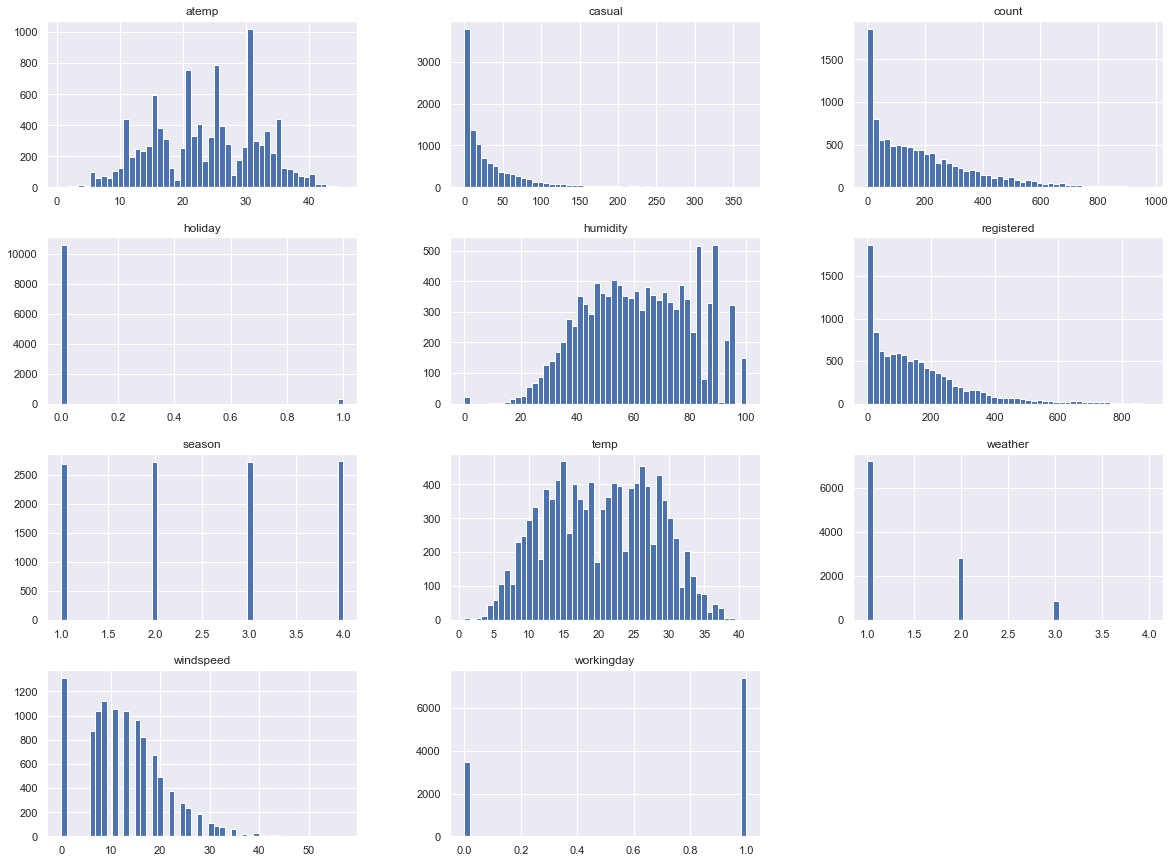

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
train.hist(bins=50, figsize=(20,15))
plt.show()

### Pandas and Dataframes

In computer programming, `pandas` is a software library written for the Python programming language for data manipulation and analysis. Data is stored in tabular format.  In particular, it offers data structures and operations for manipulating numerical tables and time series. 

The Panda Library features include:

* DataFrame object for data manipulation with integrated indexing.
* Tools for reading and writing data between in-memory data structures and different file formats.
* Data alignment and integrated handling of missing data.
* Reshaping and pivoting of data sets.
* Label-based slicing, fancy indexing, and subsetting of large data sets.
* Data structure column insertion and deletion.
* **Group by engine allowing split-apply-combine operations on data sets.**
* Data set merging and joining.
* Hierarchical axis indexing to work with high-dimensional data in a lower-dimensional data structure.
* Time series-functionality: 
  * Date range generation[3] and frequency conversion, 
  * moving window statistics, 
  * moving window linear regressions, 
  * date shifting and lagging.


For more info on Pandas dataframes see the following:

* [Pandas intro](https://pandas.pydata.org/pandas-docs/stable/dsintro.html)
* [Wiki entry for Pandas](https://en.wikipedia.org/wiki/Pandas_(software))


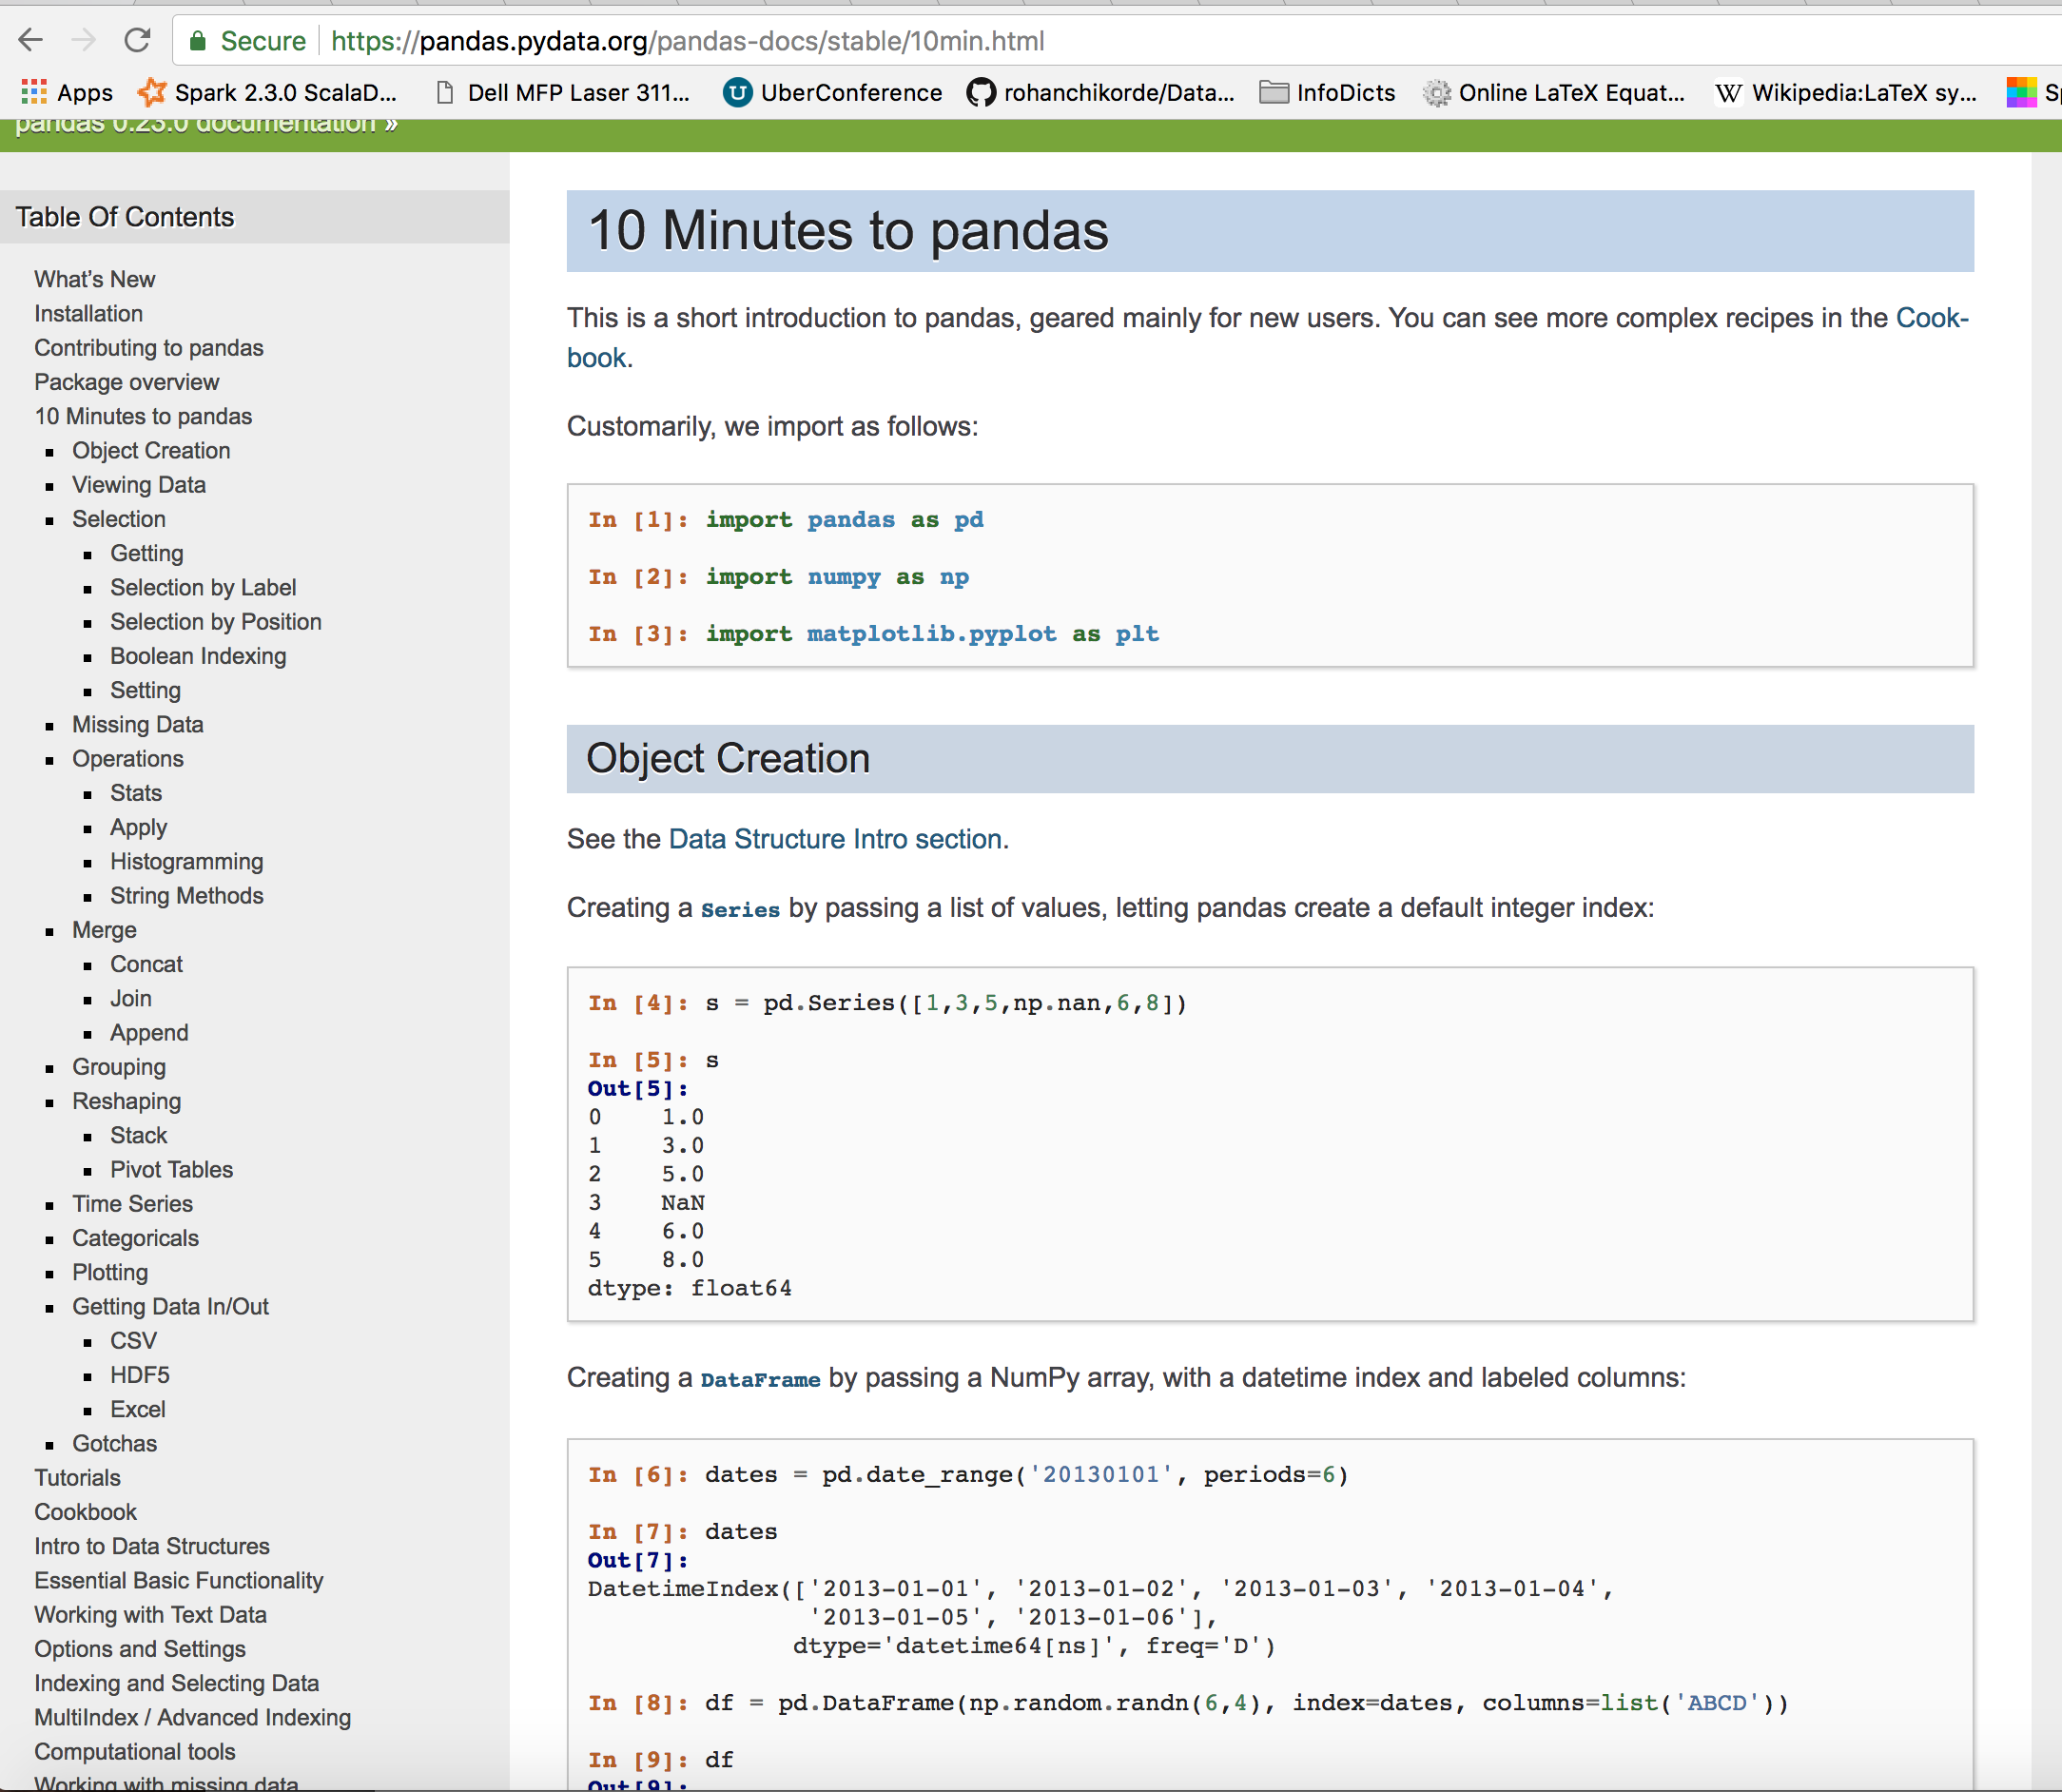



#### GROUP BY analysis: Sample use of a GROUP BY analysis: E.g., Season, or Holiday


E.g., 

* groupby(['holiday']) to see if the target value varies between holiday and not holiday.
* groupby(['season'] to see if the target value varies between holiday and not holiday.


In [47]:
train[['count', 'holiday']].groupby(['holiday'], as_index = True).mean().sort_values(by = 'count')

,count
holiday,
1,185.877814
0,191.741655


In [48]:
train[['count', 'season']].groupby(['season'], as_index = True).mean().sort_values(by = 'count')

,count
season,
1,116.343261
4,198.988296
2,215.251372
3,234.417124


#### Visualize a categorical features like Season, weather 


```
weather:    Four Categories of weather
            1-> Clear, Few clouds, Partly cloudy, Partly cloudy
            2-> Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
            3-> Light Snow and Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
            4-> Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

```

In [49]:
train.season.unique()

array([1, 2, 3, 4])

In [50]:
train.weather.value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

In [51]:
train.holiday.value_counts()

0    10575
1      311
Name: holiday, dtype: int64

/Users/jgisrael/anaconda3/envs/i526/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


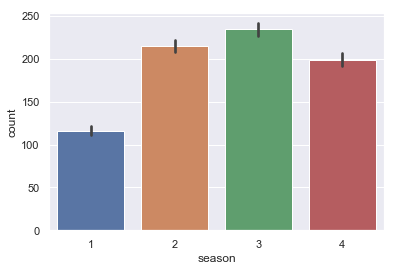

In [52]:
sns.barplot(x='season', y='count', data=train)

/Users/jgisrael/anaconda3/envs/i526/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


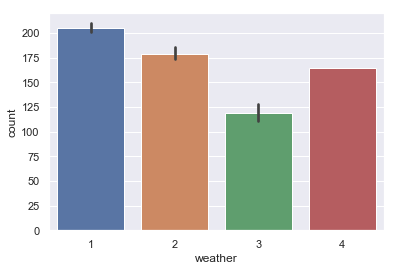

In [53]:
sns.barplot(x='weather', y='count', data=train)

## One hot encoding (OHE)
Features like season, holiday, weather and working day are in  numerical form here. Having said that the numerical values associated with feature like weather dont have any particular numeric ordering. As such, it is much better to one hot encode these features. Here we can do this manually (via code) for training and testing datasets. Later in this course we automate this process in a more principled manner (we have to deal with corner cases.  

* Further, found in the year column, there are just 2 different years 2011,2012 so using map(), we convert  2011 and 2012 to 0 and 1 respectively. 



In [54]:
# Create a new column called df.weather1 where the value is 1
# if df.weather is 1 and 0 if not
train['weather1'] = np.where(train['weather']==1, 1, 0)  #ifelse assignment
train['weather2'] = np.where(train['weather']==2, 1, 0)
train['weather3'] = np.where(train['weather']==3, 1, 0)
train['weather4'] = np.where(train['weather']==4, 1, 0)

# dont forget to drop the original feature
train.drop(['weather'], axis=1, inplace=True)

In [55]:
train.iloc[[7000]] ## Weather has a value of 2
#train.as_matrix()[322:330,]

,datetime,season,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,weather1,weather2,weather3,weather4
7000,2012-04-10 00:00:00,2,0,1,18.04,21.97,47,19.0012,3,23,26,0,1,0,0


### Dont forget to OHE the test data


Dont forget to OHE the test data!!
..........

### Are there other features that should be OHE?

Hint: Season? Others?

## Create new  features (based on timestamp)
* Well, we have a datetime feature (more like an object) in this dataset.  Let's break it into hour, day, month, year and make them a separate column.


In [56]:
train["hour"] = [t.hour for t in pd.DatetimeIndex(train.datetime)]
train["day"] = [t.dayofweek for t in pd.DatetimeIndex(train.datetime)]
train["month"] = [t.month for t in pd.DatetimeIndex(train.datetime)]
train['year'] = [t.year for t in pd.DatetimeIndex(train.datetime)]
train['year'] = train['year'].map({2011:0, 2012:1}) #OHE: One-hot-encoding (OHE): based 

## Separate input features and target feature for TRAIN ONLY.

Why separate input features and target feature for TRAIN only?

Answer: The test set is for creating a Kaggle submission.


In [57]:
X, y = train.iloc[:, 1:], train['count']
X = train.drop(['datetime','registered', 'casual', 'count'], axis=1)

In [58]:
X.iloc[0:2,:]

,season,holiday,workingday,temp,atemp,humidity,windspeed,weather1,weather2,weather3,weather4,hour,day,month,year
0,1,0,0,9.84,14.395,81,0.0,1,0,0,0,0,5,1,0
1,1,0,0,9.02,13.635,80,0.0,1,0,0,0,1,5,1,0


## Analysis of target variables

It was seen from the training data sum of registered column and casual column yields count.
It was unnecessary to keep these two columns as our features, Machine learning learners can be more fruitful if dataset is free of useless columns.

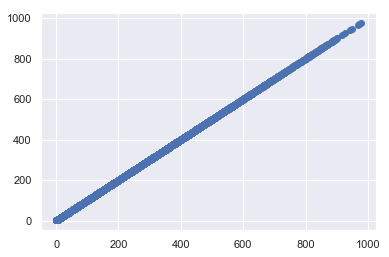

In [59]:
plt.scatter(x = train['casual'] + train['registered'], y = train['count'])
plt.show()

## Applying machine learning models (i.e., linear regression, DTs)

### Split the training data into train and a blind test set 
Split the training data into train and a blind test set using scikit's train_test_split package. Rememeber that the test set that was provided is for Kaggle submission only and as such has not target values.


In [60]:
from sklearn.model_selection import  train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

Features on larger scales can unduly influence the model.
We want features on a similar scale.
Scikit's preprocessing provides us with StandardScaler package to scale our data.

In [61]:
from sklearn.preprocessing import StandardScaler
scl= StandardScaler()
X_train_std = scl.fit_transform(X_train)
X_test_std = scl.transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_std, y_train) #SKLearn's linear regression

y_train_pred = lin_reg.predict(X_train_std)
y_test_pred = lin_reg.predict(X_test_std)

In [62]:
from sklearn.metrics import mean_squared_error, r2_score
#Root_Mean_Square Error(RMSE) is performance criteria for this problem
# errors on  count
print('RMSE train: %.3f' % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE test: %.3f' % np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('R2 train: %.3f' % r2_score(y_train, y_train_pred))
print('R2 test: %.3f' % r2_score(y_test, y_test_pred))

RMSE train: 141.620
RMSE test: 140.759
R2 train: 0.391
R2 test: 0.390


Text(0.5,1,'loglog base 2 on x')

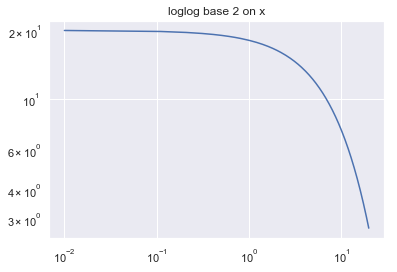

In [63]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

t = np.arange(0.01, 20.0, 0.1)

# log x and y axis
#plt.subplot(223)
plt.loglog(t, 20*np.exp(-t/10.0))# basex=2)
plt.grid(True)
plt.title('loglog base 2 on x')


### Keep a log book to track your experiments

In [64]:
expLog = pd.DataFrame(columns=["Model description", "RMSE train", 'RMSE test','R2 test'])

# add the result of this experiment to the log book
expLog.loc[len(expLog)] = ["SKLearn Linear Regression vanilla",  
                np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)),3),
                np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)),3),
                np.round(r2_score(y_test, y_test_pred), 3)
                            ]
expLog

,Model description,RMSE train,RMSE test,R2 test
0,SKLearn Linear Regression vanilla,141.62,140.759,0.39


### Learn a Decision Tree  Regressor
Let's learn a DecisionTreeRegressor model for comparison purposes.

In [65]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
dt.fit(X_train_std, y_train)
y_train_pred = dt.predict(X_train_std)
y_test_pred = dt.predict(X_test_std)
#Root_Mean_Square_Error(RMSE) is accuracy criteria for this problem
# errors on  count
print('RMSE train: %.3f' % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE test: %.3f' % np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('R2 train: %.3f' % r2_score(y_train, y_train_pred))
print('R2 test: %.3f' % r2_score(y_test, y_test_pred))     
      
expLog.loc[len(expLog)] = ["SKLearn DecisionTree vanilla",  
                np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)),3),
                np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)),3),
                np.round(r2_score(y_test, y_test_pred), 3)
                            ]
expLog


RMSE train: 0.276
RMSE test: 62.500
R2 train: 1.000
R2 test: 0.880


,Model description,RMSE train,RMSE test,R2 test
0,SKLearn Linear Regression vanilla,141.620,140.759,0.39
1,SKLearn DecisionTree vanilla,0.276,62.500,0.88


### Learn a Decision Tree ensemble, i.e., use RandomForestRegressor
Learn Decision Tree ensemble, RandomForestRegressor, model.

In [66]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators = 400, criterion='mse',random_state=1, n_jobs=-1)
forest.fit(X_train_std, y_train)
y_train_pred = forest.predict(X_train_std)
y_test_pred = forest.predict(X_test_std)

/Users/jgisrael/anaconda3/envs/i526/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [67]:
from sklearn.metrics import mean_squared_error, r2_score
#Root_Mean_Square_Log_Error(RMSE) is accuracy criteria for this problem
# errors on  count
print('RMSE train: %.3f' % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE test: %.3f' % np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('R2 train: %.3f' % r2_score(y_train, y_train_pred))
print('R2 test: %.3f' % r2_score(y_test, y_test_pred))     
      
expLog.loc[len(expLog)] = ["SKLearn RandomForestRegressor vanilla",  
                np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)),3),
                np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)),3),
                np.round(r2_score(y_test, y_test_pred), 3)
                          ]
expLog

RMSE train: 14.994
RMSE test: 42.655
R2 train: 0.993
R2 test: 0.944


,Model description,RMSE train,RMSE test,R2 test
0,SKLearn Linear Regression vanilla,141.620,140.759,0.390
1,SKLearn DecisionTree vanilla,0.276,62.500,0.880
2,SKLearn RandomForestRegressor vanilla,14.994,42.655,0.944


## Generate a submission file on the Kaggle test data.

In [68]:
test=pd.read_csv('./Kaggle-Bike-Sharing-Demand-Challenge/test.csv')
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


### Dont forget to generate features 

* from datatime object  (hour,day,month,year)
* OHE


In [69]:
# Create a new column called df.weather1 where the value is 1
# if df.weather is 1 and 0 if not
test['weather1'] = np.where(test['weather']==1, 1, 0)  #ifelse assignment
test['weather2'] = np.where(test['weather']==2, 1, 0)
test['weather3'] = np.where(test['weather']==3, 1, 0)
test['weather4'] = np.where(test['weather']==4, 1, 0)

# dont forget to drop the original feature
test.drop(['weather'], axis=1, inplace=True)

In [70]:
test["hour"] = [t.hour for t in pd.DatetimeIndex(test.datetime)]
test["day"] = [t.dayofweek for t in pd.DatetimeIndex(test.datetime)]
test["month"] = [t.month for t in pd.DatetimeIndex(test.datetime)]
test['year'] = [t.year for t in pd.DatetimeIndex(test.datetime)]
test['year'] = test['year'].map({2011:0, 2012:1})

In [71]:
test.head()

,datetime,season,holiday,workingday,temp,atemp,humidity,windspeed,weather1,weather2,weather3,weather4,hour,day,month,year
0,2011-01-20 00:00:00,1,0,1,10.66,11.365,56,26.0027,1,0,0,0,0,3,1,0
1,2011-01-20 01:00:00,1,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,3,1,0
2,2011-01-20 02:00:00,1,0,1,10.66,13.635,56,0.0000,1,0,0,0,2,3,1,0
3,2011-01-20 03:00:00,1,0,1,10.66,12.880,56,11.0014,1,0,0,0,3,3,1,0
4,2011-01-20 04:00:00,1,0,1,10.66,12.880,56,11.0014,1,0,0,0,4,3,1,0


In [72]:
X_test=test.iloc[:,1:]

Similarly, use same standarad scaler for test data

In [73]:
X_test = scl.transform(X_test)

In [74]:
y_test=forest.predict(X_test)

In [75]:
df_submit = test

In [76]:
df_submit['count'] = np.round(y_test)

In [77]:
df_submit = df_submit.drop(['season', 'holiday', 'workingday','temp', 'atemp', 'humidity', 
                            'windspeed', 'hour', 'day', 'month', 'year', 'weather1', 'weather2',
                            'weather3', 'weather4'], axis=1)

In [78]:
df_submit.head()

,datetime,count
0,2011-01-20 00:00:00,11.0
1,2011-01-20 01:00:00,6.0
2,2011-01-20 02:00:00,4.0
3,2011-01-20 03:00:00,4.0
4,2011-01-20 04:00:00,3.0


### Clip all negative predictions at zero

This is a post processing step to insure that all negative prediction values (we can not have negative bike rentals) are clipped to the value 0.

How many negative counts does your model predict? Plot a histogram using the code below. 



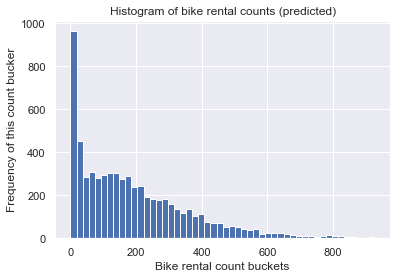

In [79]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math

# the histogram of the data
n, bins, patches = plt.hist(df_submit['count'], 50)

plt.xlabel('Bike rental count buckets')
plt.ylabel('Frequency of this count bucker')
plt.title(r'Histogram of bike rental counts (predicted)')
plt.grid(True)

plt.show()

In [80]:
df_submit['count'] = np.where(df_submit['count'] < 0, 0, df_submit['count'])

In [81]:
df_submit.to_csv('bike2.csv', index=False)

### Now upload this submission file to Kaggle

Good luck!


__Sample of submission screenshot:__

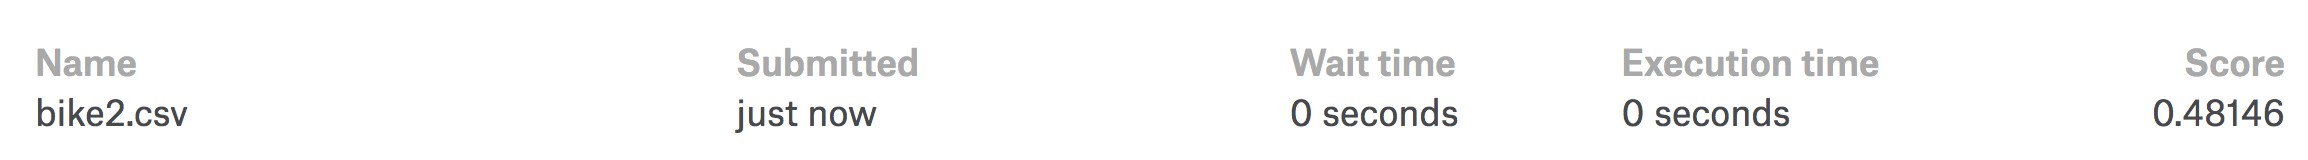

## Core TASK: Report your results

This question (this entire section) so far has  provided a lot of background and sample code that you should review, run and extend to get familar with this problem and data set. Next up you should tackle the tasks posed here.  Please feel free to adapt the above code to accomplish the following:

Overall, we want you to build a linear regression model using pipelines that builds on what was discussed earlier in this section and do a Kaggle submission for this Bike Demand prediction problem. In particular, we want you to address the following:

* Derive other features 
  * OHE features such as  season, 
 
* Please do feature selection using `SelectKBest` 
  * See a full section on Feature Selection in Lab04 Notebook for details on how to do this. 
* Please put all modeling steps (including Feature Selection) in a Pipeline **(NOTE please keep the OHE step separate preprocessing step for this homework)**
* Present your experimental results in tabular form
  * Describe the linear regression model, number of input features used, MAE, RMSE and MAPE, feature familires used (e.g., Baseline features, Season OHE, etc.).
* Please do a Kaggle submission with your best linear regression model
* Screenshot your kaggle submission results
* Discuss your best result (in terms of process followed, features used and any other interesting discoveries that you came across). 

### Reload original train data

In [82]:
train=pd.read_csv('Kaggle-Bike-Sharing-Demand-Challenge/train.csv')
train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


### OHE encoding on season feature (train)

In [83]:
# Create a new column called df.season1 where the value is 1
# if df.season is 1 and 0 if not
train['season1'] = np.where(train['season']==1, 1, 0)  #ifelse assignment
train['season2'] = np.where(train['season']==2, 1, 0)
train['season3'] = np.where(train['season']==3, 1, 0)
train['season4'] = np.where(train['season']==4, 1, 0)

# dont forget to drop the original feature
train.drop(['season'], axis=1, inplace=True)

In [84]:
# Create a new column called df.weather1 where the value is 1
# if df.weather is 1 and 0 if not
train['weather1'] = np.where(train['weather']==1, 1, 0)  #ifelse assignment
train['weather2'] = np.where(train['weather']==2, 1, 0)
train['weather3'] = np.where(train['weather']==3, 1, 0)
train['weather4'] = np.where(train['weather']==4, 1, 0)

# dont forget to drop the original feature
train.drop(['weather'], axis=1, inplace=True)

In [85]:
train["hour"] = [t.hour for t in pd.DatetimeIndex(train.datetime)]
train["day"] = [t.dayofweek for t in pd.DatetimeIndex(train.datetime)]
train["month"] = [t.month for t in pd.DatetimeIndex(train.datetime)]
train['year'] = [t.year for t in pd.DatetimeIndex(train.datetime)]
train['year'] = train['year'].map({2011:0, 2012:1})

### Separate x, y data and the training data into a train and validation sets

In [86]:
X_train = train.iloc[:,1:].copy()
X_train.drop(columns=['casual', 'registered', 'count'], inplace=True)
y_train = train['count'].copy()

In [87]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('Train (x,y):\t', X_train.shape,'\t',y_train.shape)
print('Validate (x,y):\t', X_val.shape,'\t',y_val.shape)

Train (x,y):	 (8708, 18) 	 (8708,)
Validate (x,y):	 (2178, 18) 	 (2178,)


### SelectKBest feature selection (using the TopFeatureSelector method from Lab 04)

In [88]:
from sklearn.feature_selection import SelectKBest, f_regression
#k is an arbitrary number of features 
#we will use our pipeline below to select based on p values
Kbest = SelectKBest(f_regression, k=5) 
X_train_sel = Kbest.fit_transform(X_train, y_train)

In [89]:
featureScores = Kbest.scores_
pd.DataFrame({'F statistic':Kbest.scores_,'p value':Kbest.pvalues_}).sort_values(by='p value')

,F statistic,p value
14,1673.869106,0.000000e+00
2,1561.939217,2.423997e-314
3,1524.175960,2.262803e-307
4,979.907570,6.178436e-204
17,628.233428,6.245283e-134
6,498.940898,1.626842e-107
16,241.552239,9.476690e-54
8,149.919769,3.446001e-34
12,123.668940,1.548798e-28
10,103.116591,4.303202e-24


In [90]:
from sklearn.base import BaseEstimator, TransformerMixin

# find the indices to the top ranking input features based on importance 
#    arr is an array of feature importances in order of the input data matrix X
#    k is the number of features to be selected
#
# Note: this feature selector assumes that you have already computed the feature importances 
# We did so in the cell above with the feature importance scores stored in Kbest.scores_ 

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    # select the columns of data matrix of the selected input features 
    def transform(self, X):
        return X[:, self.feature_indices_]

### Build a full pipeline using Linear Regression

In [91]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
linreg = LinearRegression()
pipe = Pipeline([
        ("MinMaxScaler", MinMaxScaler()),
        ('feature_selection', TopFeatureSelector(featureScores, 13)), # k=13 based on p values above
        ('linreg', LinearRegression())
    ])

### Fit train data and generate predictions on the validation data

In [92]:
pipe.fit(X_train, y_train) 
y_val_pred = pipe.predict(X_val)

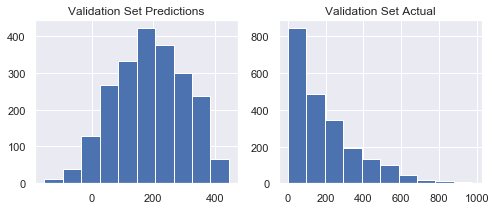

In [93]:
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.hist(y_val_pred)
plt.title('Validation Set Predictions')
plt.subplot(122)
plt.hist(y_val)
plt.title('Validation Set Actual');

In [94]:
# set a lower bound for predicted values at zero
# and set all predictions to integer (count)
y_val_pred = np.where(y_val_pred < 0, 0, y_val_pred.astype(int))

That's a little more realistic, but still doesn't appear to be distributed like our ground truth.

[230  37 196 280 396 316 194 285 181  29]


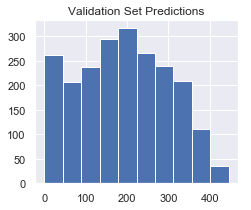

In [95]:
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.hist(y_val_pred)
plt.title('Validation Set Predictions')
print(y_val_pred[:10])

Generate statistics on the predictions.

In [96]:
expLog = pd.DataFrame(columns=['Model Description', 'MAE', 'RMSE', "MAPE"])
mae = mean_absolute_error(y_val, y_val_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
mape = mean_absolute_percentage_error(y_val, y_val_pred)
expLog.loc[len(expLog)] = ['SKLearn LinReg SelectKBest=13', mae, rmse, mape]

In [97]:
expLog

,Model Description,MAE,RMSE,MAPE
0,SKLearn LinReg SelectKBest=13,102.898072,139.806448,295.100932


### Prepare a Kaggle submission using our pipeline model

#### Re-load the Kaggle test data

In [98]:
test=pd.read_csv('./Kaggle-Bike-Sharing-Demand-Challenge/test.csv')

#### Perform the same OHE steps as we did on training data

In [99]:
# Create a new column called df.weather1 where the value is 1
# if df.weather is 1 and 0 if not
test['weather1'] = np.where(test['weather']==1, 1, 0)  #ifelse assignment
test['weather2'] = np.where(test['weather']==2, 1, 0)
test['weather3'] = np.where(test['weather']==3, 1, 0)
test['weather4'] = np.where(test['weather']==4, 1, 0)

# dont forget to drop the original feature
test.drop(['weather'], axis=1, inplace=True)

In [100]:
# Create a new column called df.season1 where the value is 1
# if df.season is 1 and 0 if not
test['season1'] = np.where(test['season']==1, 1, 0)  #ifelse assignment
test['season2'] = np.where(test['season']==2, 1, 0)
test['season3'] = np.where(test['season']==3, 1, 0)
test['season4'] = np.where(test['season']==4, 1, 0)

# dont forget to drop the original feature
test.drop(['season'], axis=1, inplace=True)

In [101]:
test["hour"] = [t.hour for t in pd.DatetimeIndex(test.datetime)]
test["day"] = [t.dayofweek for t in pd.DatetimeIndex(test.datetime)]
test["month"] = [t.month for t in pd.DatetimeIndex(test.datetime)]
test['year'] = [t.year for t in pd.DatetimeIndex(test.datetime)]
test['year'] = test['year'].map({2011:0, 2012:1})

In [102]:
X_test = test.iloc[:,1:].copy()

In [103]:
# generate predictions and apply the same post-processing
y_test = pipe.predict(X_test)
y_test = np.where(y_test < 0, 0, y_test.astype(int))

In [104]:
# create dataframe in the form expected by Kaggle
df_submit = pd.DataFrame({'datetime':test['datetime'],'count':y_test})
df_submit = df_submit[['datetime','count']]
df_submit.head(10)

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0
5,2011-01-20 05:00:00,0
6,2011-01-20 06:00:00,0
7,2011-01-20 07:00:00,2
8,2011-01-20 08:00:00,11
9,2011-01-20 09:00:00,24


In [105]:
df_submit.to_csv('bike3.csv', index=False)

# Core task: bike demand extension 1 (2 separate LR models)

Build separate linear regression models for the other target variables (instead of the `count` target variable) and report your results:  

`
registered: number of registered user
casual:     number of non-registered user
`

Overall, we want you to build a linear regression model using pipelines that builds on what you learned as a solution to the previous section,   and do a Kaggle submission for this Bike Demand prediction problem. In particular, we want you to address (using what you have done previously) the following:

* Derive other features 
  * OHE features such as  season
  * Other derived features? [optional]
* Please do feature selection using `SelectKBest` 
  * See a full section on Feature Selection in Lab04 Notebook for details on how to do this. 
* Please put all modeling steps (including Feature Selection) in a Pipeline **(NOTE please keep the OHE step separate preprocessing step for this homework)**
* Present your experimental results in tabular form
  * Describe the linear regression model, number of input features used, MAE, RMSE and MAPE, feature families used (e.g., Baseline features, Season OHE, etc.).
* Discuss your best result (in terms of process followed, features used and any other interesting discoveries that you came across). Were the selected features here the same as what you selected in your solution to Section 6? 


## Load data

### Reload training data

In [106]:
train=pd.read_csv('Kaggle-Bike-Sharing-Demand-Challenge/train.csv')
train.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16


### OHE for wather and season; generate time and date features

In [107]:
train['weather1'] = np.where(train['weather']==1, 1, 0)  #ifelse assignment
train['weather2'] = np.where(train['weather']==2, 1, 0)
train['weather3'] = np.where(train['weather']==3, 1, 0)
train['weather4'] = np.where(train['weather']==4, 1, 0)

train['season1'] = np.where(train['season']==1, 1, 0)  #ifelse assignment
train['season2'] = np.where(train['season']==2, 1, 0)
train['season3'] = np.where(train['season']==3, 1, 0)
train['season4'] = np.where(train['season']==4, 1, 0)

# dont forget to drop the original feature
train.drop(['season'], axis=1, inplace=True)
train.drop(['weather'], axis=1, inplace=True)

train["hour"] = [t.hour for t in pd.DatetimeIndex(train.datetime)]
train["day"] = [t.dayofweek for t in pd.DatetimeIndex(train.datetime)]
train["month"] = [t.month for t in pd.DatetimeIndex(train.datetime)]
train['year'] = [t.year for t in pd.DatetimeIndex(train.datetime)]
train['year'] = train['year'].map({2011:0, 2012:1}) #OHE: One-hot-encoding (OHE): based 

### Separate x, y data and perform train_test_split on training data only

In [108]:
X = train.drop(['datetime','registered', 'casual', 'count'], axis=1)
y_reg, y_cas = train['registered'], train['casual']

In [109]:
# We can ensure the same split for both targets by setting the same random_state for both splits
X_train, X_val, y_train_reg, y_val_reg = train_test_split(X, y_reg, test_size=.3, random_state=0)
_, _, y_train_cas, y_val_cas = train_test_split(X, y_cas, test_size=.3, random_state=0)

In [110]:
print('Train (x,y):\t', X_train.shape,'\t',y_train_reg.shape,'\t',y_train_cas.shape)
print('Validate (x,y):\t', X_val.shape,'\t',y_val_reg.shape,'\t',y_val_cas.shape)

Train (x,y):	 (7620, 18) 	 (7620,) 	 (7620,)
Validate (x,y):	 (3266, 18) 	 (3266,) 	 (3266,)


## Select K best features registered and casual targets

In [111]:
from sklearn.feature_selection import SelectKBest, f_regression
Kbest = SelectKBest(f_regression, k=7)#
Kbest_reg = Kbest.fit(X_train, y_train_reg)
#X_train_reg = Kbest_reg.fit_transform(X_train, y_train_reg)

Kbest_cas = SelectKBest(f_regression, k=7)
Kbest_cas = Kbest.fit(X_train, y_train_cas)
#X_train_cas = Kbest_cas.fit_transform(X_train, y_train_cas)

In [112]:
# training data correlates similarly to both target variables
df_reg = pd.DataFrame({'F statistic (reg)':Kbest_reg.scores_,'p value (reg)':Kbest_reg.pvalues_}).sort_values(by='p value (reg)')
df_cas = pd.DataFrame({'F statistic (cas)':Kbest_cas.scores_,'p value (cas)':Kbest_cas.pvalues_}).sort_values(by='p value (cas)')
df_reg.join(df_cas)

,F statistic (reg),p value (reg),F statistic (cas),p value (cas)
2,2185.595067,0.000000e+00,2185.595067,0.000000e+00
3,2120.362611,0.000000e+00,2120.362611,0.000000e+00
4,1014.044057,5.023065e-209,1014.044057,5.023065e-209
1,841.617133,1.303198e-175,841.617133,1.303198e-175
14,780.018610,1.656453e-163,780.018610,1.656453e-163
10,471.600445,1.641715e-101,471.600445,1.641715e-101
15,451.598301,2.086401e-97,451.598301,2.086401e-97
12,283.707495,1.566993e-62,283.707495,1.566993e-62
11,149.212608,5.351810e-34,149.212608,5.351810e-34
17,146.506982,2.035539e-33,146.506982,2.035539e-33


## Fit train data and generate predictions on the "test" split of training data

Because we used a pipeline, we can easily generate predictions on two targets using the same model

### First using Kbest features for registered target

In [113]:
featureScores = Kbest_reg.scores_
pipe.fit(X_train, y_train_reg) 
y_pred_reg = pipe.predict(X_val)

### Then using Kbest features for casual target

In [114]:
featureScores = Kbest_cas.scores_
pipe.fit(X_train, y_train_cas) 
y_pred_cas = pipe.predict(X_val)

In [115]:
y_pred_reg = np.where(y_pred_reg < 0, 0, np.round(y_pred_reg).astype(int))
y_pred_cas = np.where(y_pred_cas < 0, 0, np.round(y_pred_cas).astype(int))

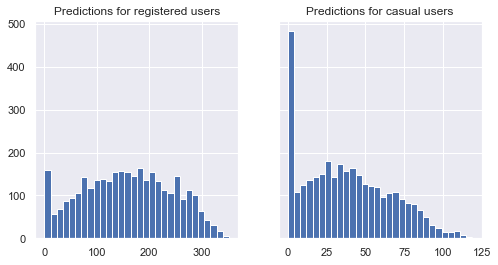

In [116]:
### Visualize results
fig, ax = plt.subplots(1,2,sharey=True)
fig.set_figwidth(8)
ax[0].hist(y_pred_reg, bins=30)
ax[0].set_title('Predictions for registered users')
ax[1].hist(y_pred_cas, bins=30)
ax[1].set_title('Predictions for casual users');

## Report results

In [117]:
mae = mean_absolute_error(y_val_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_val_reg, y_pred_reg))
mape = mean_absolute_percentage_error(y_val_reg, y_pred_reg)
expLog.loc[len(expLog)] = ['SKLearn LinReg for "registered"', mae, rmse, mape]

mae = mean_absolute_error(y_val_cas, y_pred_cas)
rmse = np.sqrt(mean_squared_error(y_val_cas, y_pred_cas))
mape = mean_absolute_percentage_error(y_val_cas, y_pred_cas)
expLog.loc[len(expLog)] = ['SKLearn LinReg for "casual"', mae, rmse, mape]

/Users/jgisrael/anaconda3/envs/i526/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/Users/jgisrael/anaconda3/envs/i526/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


MAPE is undefined for registered and casual models because each includes zeros among the actual (true) target values.

In [118]:
expLog

,Model Description,MAE,RMSE,MAPE
0,SKLearn LinReg SelectKBest=13,102.898072,139.806448,295.100932
1,"SKLearn LinReg for ""registered""",86.127679,122.366619,NaN
2,"SKLearn LinReg for ""casual""",24.411513,40.084708,NaN


# Core task: bike demand extension 2 (target = log(demand+1))

The distribution of the raw `count` feature is very skewed with most values occuring to the left of the count domain. To make this distribution less skewed (and more normal distributed, it is common to take the log of the value + 1 (to avoid log(0)). 

* log(count+1)
* then just do regression as usual
* Do NOT forget to take the inverse of the log(count +1) before doing a Kaggle submissions. e.g., np.exp(pred) - 1 to get back to real count scale.

Overall, we want you to build a linear regression model (single model will suffice based on the `count` target) using pipelines that builds on what you learned as a solution to the previous section,   and do a Kaggle submission for this Bike Demand prediction problem. In particular, we want you to address (using what you have done previously) the following:

* Derive other features 
  * OHE features such as  season, 
  * If barplot demand over each hour of the the day, you will notice interesting patterns. E.g., you might be able to  segregate the bike demand in three hourly categories, like the following:

      ```
         High       : 7-9 and 17-19 hours
         Average    : 10-16 hours
         Low        : 0-6 and 20-24 hours
```
* Perform feature selection using `Sequential Backward Selection` algorithm
  * See a full section on Sequential Backward Selection for regression in Lab05 Notebook for details on how to do this. 
* Please put all modeling steps in a Pipeline 
  * NOTE please keep the OHE step separate preprocessing step for this homework
  * Feature Selection can be performed prior to the pipeline or as part of the pipeline. Please discuss what you choose and why.
* Present your experimental results in tabular form
  * Describe the linear regression model, number of input features used, MAE, RMSE and MAPE, feature familires used (e.g., Baseline features, Season OHE, etc.).
* Please do a Kaggle submission with your best linear regression model
    * Screenshot your kaggle submission results
* Discuss your best result (in terms of process followed, features used and any other interesting discoveries that you came across). Were the selected features here the same as what you selected in your solution to Section 6? 



## Load data

### Reload training data

In [119]:
train=pd.read_csv('Kaggle-Bike-Sharing-Demand-Challenge/train.csv')
train.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16


### OHE for wather and season; generate time and date features

In [120]:
train['weather1'] = np.where(train['weather']==1, 1, 0)  #ifelse assignment
train['weather2'] = np.where(train['weather']==2, 1, 0)
train['weather3'] = np.where(train['weather']==3, 1, 0)
train['weather4'] = np.where(train['weather']==4, 1, 0)

train['season1'] = np.where(train['season']==1, 1, 0)  #ifelse assignment
train['season2'] = np.where(train['season']==2, 1, 0)
train['season3'] = np.where(train['season']==3, 1, 0)
train['season4'] = np.where(train['season']==4, 1, 0)

# dont forget to drop the original feature
train.drop(['season'], axis=1, inplace=True)
train.drop(['weather'], axis=1, inplace=True)

train["hour"] = [t.hour for t in pd.DatetimeIndex(train.datetime)]
train["day"] = [t.dayofweek for t in pd.DatetimeIndex(train.datetime)]
train["month"] = [t.month for t in pd.DatetimeIndex(train.datetime)]
train['year'] = [t.year for t in pd.DatetimeIndex(train.datetime)]
train['year'] = train['year'].map({2011:0, 2012:1}) #OHE: One-hot-encoding (OHE): based 

### Prepare the train data

#### Separate x, y from the train data and log transform y

In [121]:
X, y = train.iloc[:, 1:], train['count']
X = X.drop(['registered', 'casual', 'count'], axis=1)
y = np.log(y+1)

Note that zeros no longer dominate other target values in transformed data

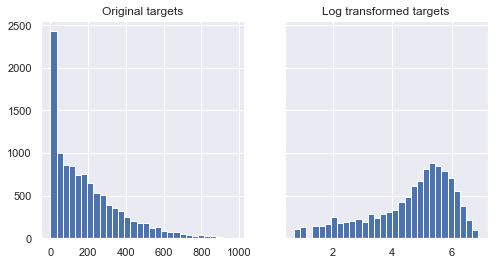

In [122]:
### Visualize target transformation
fig, ax = plt.subplots(1,2,sharey=True)
fig.set_figwidth(8)
ax[0].hist(train['count'], bins=30)
ax[0].set_title('Original targets')
ax[1].hist(y, bins=30)
ax[1].set_title('Log transformed targets');

In [123]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=0)

## Sequential Backward Selection

In [124]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)
        
        print(X_train.shape, y_train.shape)
        print(X_test.shape, y_test.shape)
        dim = X_train.shape[1]
        self.indices_ = list(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, list(p))
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train.iloc[:, indices], y_train)
        y_pred = self.estimator.predict(X_test.iloc[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [125]:
from sklearn.metrics import explained_variance_score
lr = LinearRegression()
sbs = SBS(lr, 1, scoring=explained_variance_score)
sbs.fit(X_train, y_train)

(6531, 18) (6531,)
(2177, 18) (2177,)


Beyond 5 features there is not much additional benefit in terms of explained variance.

Text(0.5,0,'number of features')

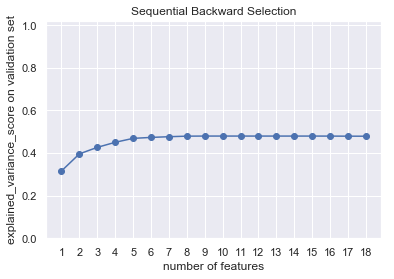

In [126]:
# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

#plot places the points on the graph using the number of features (no need to sort!)
plt.plot(k_feat, sbs.scores_, marker='o')  
plt.xticks(k_feat)
plt.ylim([0.0, 1.02])
plt.title("Sequential Backward Selection")
plt.ylabel('explained_variance_score on validation set')
plt.xlabel(r'number of features')

Modify TopFeatureSelector to select the k-th subset our SBS object

In [127]:
class SBSFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, subsets, k):
        self.subsets = subsets
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = sbs.subsets_[len(self.subsets)-self.k]  # pull the k-th subset from the end
        return self
    # select the columns of data matrix of the selected input features 
    def transform(self, X):
        return X[:, self.feature_indices_]

## Build a regression model (with a Pipeline)

In [128]:
pipe = Pipeline([
        ("std_scaler", StandardScaler()),
        ('feature_selection', SBSFeatureSelector(sbs.subsets_, k=5)),
        ('linreg', LinearRegression())
    ])
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature_selection', SBSFeatureSelector(k=5,
          subsets=[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17), (2, 3, 4, 5, 6, 7, 8, 9, 10, ... (14,)])), ('linreg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

### Generate predictions

In [129]:
y_val_pred = pipe.predict(X_val)

### Present results

In [130]:
mae = mean_absolute_error(y_val, y_val_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
mape = mean_absolute_percentage_error(y_val, y_val_pred)
expLog.loc[len(expLog)] = ['SKLearn LinReg SBS=5 Log Targets', mae, rmse, mape]

In [131]:
expLog

,Model Description,MAE,RMSE,MAPE
0,SKLearn LinReg SelectKBest=13,102.898072,139.806448,295.100932
1,"SKLearn LinReg for ""registered""",86.127679,122.366619,NaN
2,"SKLearn LinReg for ""casual""",24.411513,40.084708,NaN
3,SKLearn LinReg SBS=5 Log Targets,0.815708,1.030209,27.506962


## Prepare a Kaggle submisison

### Load and preprocess Kaggle test data

In [132]:
test=pd.read_csv('./Kaggle-Bike-Sharing-Demand-Challenge/test.csv')

In [133]:
# Create a new column called df.weather1 where the value is 1
# if df.weather is 1 and 0 if not
test['weather1'] = np.where(test['weather']==1, 1, 0)  #ifelse assignment
test['weather2'] = np.where(test['weather']==2, 1, 0)
test['weather3'] = np.where(test['weather']==3, 1, 0)
test['weather4'] = np.where(test['weather']==4, 1, 0)

# dont forget to drop the original feature
test.drop(['weather'], axis=1, inplace=True)

In [134]:
# Create a new column called df.season1 where the value is 1
# if df.season is 1 and 0 if not
test['season1'] = np.where(test['season']==1, 1, 0)  #ifelse assignment
test['season2'] = np.where(test['season']==2, 1, 0)
test['season3'] = np.where(test['season']==3, 1, 0)
test['season4'] = np.where(test['season']==4, 1, 0)

# dont forget to drop the original feature
test.drop(['season'], axis=1, inplace=True)

In [135]:
test["hour"] = [t.hour for t in pd.DatetimeIndex(test.datetime)]
test["day"] = [t.dayofweek for t in pd.DatetimeIndex(test.datetime)]
test["month"] = [t.month for t in pd.DatetimeIndex(test.datetime)]
test['year'] = [t.year for t in pd.DatetimeIndex(test.datetime)]
test['year'] = test['year'].map({2011:0, 2012:1})

In [136]:
X_test = test.iloc[:,1:]

### Generate predictions using pipeline and best features (as determined by SBS) only

#### Generate predictions

In [137]:
y_pred_log = pipe.predict(X_test)

#### Transform back to original scale and integer values (counts)

In [138]:
y_pred = np.exp(y_pred_log)-1
y_pred = np.round(y_pred).astype(int)

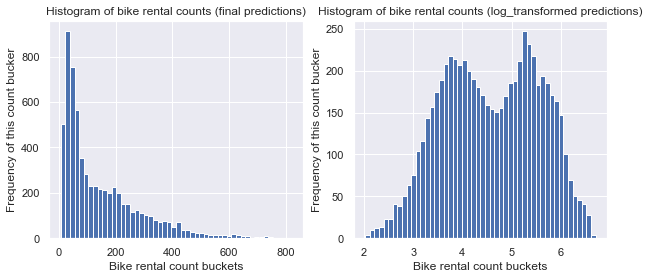

In [139]:
# Compare original target distribution with log transformed distribution

plt.figure(figsize=(10,4))
plt.subplot(121)
n, bins, patches = plt.hist(y_pred, 50)
plt.xlabel('Bike rental count buckets')
plt.ylabel('Frequency of this count bucker')
plt.title(r'Histogram of bike rental counts (final predictions)')
plt.grid(True)
plt.subplot(122)
n, bins, patches = plt.hist(y_pred_log, 50)

plt.xlabel('Bike rental count buckets')
plt.ylabel('Frequency of this count bucker')
plt.title(r'Histogram of bike rental counts (log_transformed predictions)')
plt.grid(True)
plt.show()

### Present Kaggle predictions in the format required for submission

In [140]:
# create dataframe in the form expected by Kaggle
df_submit = pd.DataFrame({'datetime':test['datetime'],'count':y_pred})
df_submit = df_submit[['datetime','count']]
df_submit.head(10)

,datetime,count
0,2011-01-20 00:00:00,12
1,2011-01-20 01:00:00,13
2,2011-01-20 02:00:00,15
3,2011-01-20 03:00:00,16
4,2011-01-20 04:00:00,18
5,2011-01-20 05:00:00,18
6,2011-01-20 06:00:00,20
7,2011-01-20 07:00:00,23
8,2011-01-20 08:00:00,26
9,2011-01-20 09:00:00,31


In [141]:
df_submit.to_csv('bike4.csv', index=False)

#  Core task: bike demand extension 3 (LR +  Regularization)

## L1 and L2 regularization for Linear Regression
Regularization is a way of penalizing the model for excessive complexity, and this helps reduce the risk of  overfitting.

There are many ways of doing regularization but these two are the major ones:
* **L2-regularization:**
$$
f(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^{n}\left[ (\mathbf{w}\cdot\mathbf{x}_i + b) - y_i\right]^2 + \lambda \sum_{j=1}^{m}w_j^2
$$
or in matrix way:
$$
f(\mathbf{w}, b) = \|\text{X}\cdot\mathbf{w} + b\cdot\mathbf{1}_n - \mathbf{y}\|_2^2 + \lambda \|\mathbf{w}\|_2^2
$$
* **L1-regularization:**
$$
f(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^{n}\left[ (\mathbf{w}\cdot\mathbf{x}_i + b) - y_i\right]^2 + \lambda \sum_{j=1}^{m}|w_j|
$$
or in matrix way:
$$
f(\mathbf{w}, b) = \|\text{X}\cdot\mathbf{w} + b\cdot\mathbf{1}_n - \mathbf{y}\|_2^2 + \lambda \|\mathbf{w}\|_1
$$

Use SKLearn Ridge and LASSO linear regression classes to perform feature selection. Use gridsearch to determine best value for $\alpha$ the mixing coefficent associated with the penalty term in regularized linear regression.

* Please put all modeling steps in a Pipeline
* NOTE please keep the OHE step separate preprocessing step for this homework
* Present your experimental results in tabular form
* Describe the linear regression model, number of input features used, MAE, RMSE and MAPE, feature familires used (e.g., Baseline features, Season OHE, etc.).
* Please do a Kaggle submission with your best linear regression model
    * Screenshot your kaggle submission results
* Discuss your best result (in terms of process followed, features used and any other interesting discoveries that you came across). Were the selected features here the same as what you selected in your solution to Section 8?

## Reload and restore the training data

In [142]:
train=pd.read_csv('Kaggle-Bike-Sharing-Demand-Challenge/train.csv')

train['weather1'] = np.where(train['weather']==1, 1, 0)  #ifelse assignment
train['weather2'] = np.where(train['weather']==2, 1, 0)
train['weather3'] = np.where(train['weather']==3, 1, 0)
train['weather4'] = np.where(train['weather']==4, 1, 0)

train['season1'] = np.where(train['season']==1, 1, 0)  #ifelse assignment
train['season2'] = np.where(train['season']==2, 1, 0)
train['season3'] = np.where(train['season']==3, 1, 0)
train['season4'] = np.where(train['season']==4, 1, 0)

# dont forget to drop the original feature
train.drop(['season'], axis=1, inplace=True)
train.drop(['weather'], axis=1, inplace=True)

train["hour"] = [t.hour for t in pd.DatetimeIndex(train.datetime)]
train["day"] = [t.dayofweek for t in pd.DatetimeIndex(train.datetime)]
train["month"] = [t.month for t in pd.DatetimeIndex(train.datetime)]
train['year'] = [t.year for t in pd.DatetimeIndex(train.datetime)]
train['year'] = train['year'].map({2011:0, 2012:1}) #OHE: One-hot-encoding (OHE): based 

X, y = train.iloc[:, 1:], train['count']
X = X.drop(['registered', 'casual', 'count'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)


## Build GridSearch pipeline to compare alpha combinations using Ridge and Lasso 

In [143]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [144]:
estimators = [('ridge', Ridge()),
              ('lasso', Lasso())]

best_score = []
best_param = []
for estimator in estimators:
    params = {estimator[0]+'__alpha':[.01, .05, .1, .5, 1, 5]}
    pipe = Pipeline([('scalar', StandardScaler()), estimator])
    gs = GridSearchCV(pipe, params, scoring='neg_mean_squared_error', cv=5)

    gs.fit(X_train, y_train)
    best_score.append(gs.best_score_)
    best_param.append(gs.best_params_)
best_idx = np.argmax(best_score)
print('Best model is:', estimators[best_idx][0], 'with parameter', best_param[best_idx])

Best model is: lasso with parameter {'lasso__alpha': 0.5}


## Generate predictions using best combination and report results in table

In [145]:
estimator = ('lasso', Lasso(alpha=.5))
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scalar', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [146]:
y_pred = pipe.predict(X_test)

In [147]:
mae = mean_absolute_error(y_pred, y_test)
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
mape = mean_absolute_percentage_error(y_pred, y_test)
expLog.loc[len(expLog)] = ['SKLearn Linear Regression GS (Lasso, alpha=.5)', mae, rmse, mape]

In [148]:
expLog

,Model Description,MAE,RMSE,MAPE
0,SKLearn LinReg SelectKBest=13,102.898072,139.806448,295.100932
1,"SKLearn LinReg for ""registered""",86.127679,122.366619,NaN
2,"SKLearn LinReg for ""casual""",24.411513,40.084708,NaN
3,SKLearn LinReg SBS=5 Log Targets,0.815708,1.030209,27.506962
4,"SKLearn Linear Regression GS (Lasso, alpha=.5)",105.346978,140.194017,94.149666


## Prepare a Kaggle submission

### Load and preprocess Kaggle test data

In [149]:
test=pd.read_csv('./Kaggle-Bike-Sharing-Demand-Challenge/test.csv')

In [150]:
# Create a new column called df.weather1 where the value is 1
# if df.weather is 1 and 0 if not
test['weather1'] = np.where(test['weather']==1, 1, 0)  #ifelse assignment
test['weather2'] = np.where(test['weather']==2, 1, 0)
test['weather3'] = np.where(test['weather']==3, 1, 0)
test['weather4'] = np.where(test['weather']==4, 1, 0)

# dont forget to drop the original feature
test.drop(['weather'], axis=1, inplace=True)

# Create a new column called df.season1 where the value is 1
# if df.season is 1 and 0 if not
test['season1'] = np.where(test['season']==1, 1, 0)  #ifelse assignment
test['season2'] = np.where(test['season']==2, 1, 0)
test['season3'] = np.where(test['season']==3, 1, 0)
test['season4'] = np.where(test['season']==4, 1, 0)

# dont forget to drop the original feature
test.drop(['season'], axis=1, inplace=True)

test["hour"] = [t.hour for t in pd.DatetimeIndex(test.datetime)]
test["day"] = [t.dayofweek for t in pd.DatetimeIndex(test.datetime)]
test["month"] = [t.month for t in pd.DatetimeIndex(test.datetime)]
test['year'] = [t.year for t in pd.DatetimeIndex(test.datetime)]
test['year'] = test['year'].map({2011:0, 2012:1})

X_test = test.iloc[:,1:]

### Generate predictions using best regularization pipeline

In [151]:
y_pred = pipe.predict(X_test)
y_pred = np.where(y_pred < 0, 0, np.round(y_pred).astype(int))

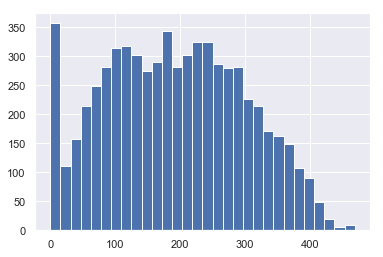

In [152]:
plt.hist(y_pred, bins=30);

In [153]:
df_submit = pd.DataFrame({'datetime':test['datetime'],'count':y_pred})
df_submit = df_submit[['datetime','count']]
df_submit.head(10)

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0
5,2011-01-20 05:00:00,0
6,2011-01-20 06:00:00,0
7,2011-01-20 07:00:00,8
8,2011-01-20 08:00:00,16
9,2011-01-20 09:00:00,40


Why didn't we use feature selection for this problem?

In [154]:
# note that Lasso regularization zeroed out several of the features 
pipe.named_steps.lasso.coef_

array([ -0.45208974,   0.43727383,  48.06757688,  14.73166647,
       -36.78380154,   1.24930465,  -0.        ,   1.99189168,
        -8.1684485 ,   0.        ,  -0.        ,   0.13073361,
       -17.35883236,   0.        ,  53.3459672 ,  -0.        ,
        26.56375058,  38.98301901])

# Optional Task: Linear Regression via GD from scratch

The objective function of linear regression is the following:
$$
f(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^{n}\left[ (\mathbf{w}\cdot\mathbf{x}_i + b) - y_i\right]^2,\\
n = \left|X_{\text{train}}\right|
$$
So we want to minimize the **squared value** of difference between predictions and real answers. It is called Mean Squared Error (MSE). Gradient Descent is the way of optimizing this complex functional and tune weigths $\mathbf{w}$ and bias $b$.

To be able to treat weigths $\mathbf{w}$ and bias $b$ homogeneously we're going to augment the data with the "shell" feature (all $1$'s). Then we can add one more parameter to the weight vector and treat it as a *bias*.
$$
\mathbf{x}' :=
\begin{bmatrix}
\mathbf{x}\\
1
\end{bmatrix},\quad
\boldsymbol{\theta} :=
\begin{bmatrix}
\mathbf{w}\\
b
\end{bmatrix}
\\
f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i\right]^2
$$
In this way it is much more easier to carry out oprimization process.

To simplify it further and do it in "*tensor*" way let's rewrite it in matrix form. Let's introduce data matrix (the same as dataframe we used everywhere above)

$$
\text{X}' =
\begin{bmatrix}
\mathbf{x'}_1^{\text{T}}\\
\vdots\\
\mathbf{x'}_n^{\text{T}}
\end{bmatrix},\quad
\mathbf{y} = 
\begin{bmatrix}
y_1\\
\vdots\\
y_n
\end{bmatrix}
$$

Matrix $\text{X}$ contains objects in its rows and features in its columns. Vector $\mathbf{y}$ is a vector of answers. Then the objective can be rewritten as follows:

$$
f(\boldsymbol{\theta}) = \frac{1}{n}\|\text{X}'\cdot \boldsymbol{\theta} - \mathbf{y}\|_2^2
$$

Then the gradient can be easily calculated in vectorized form:

$$
\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{2}{n}\,\text{X}'^{\text{T}}\left(\text{X}'\cdot \boldsymbol{\theta} - \mathbf{y}\right)
$$

Exactly this computations are implemented down below in **BasicLinearRegressionHomegrown** class

## Data

Split into train and test set (with the same $\text{random_state}$ which means we can compare results)

In [155]:
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaling

In [157]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Basic version of homegrown Linear Regression

In [158]:
class BasicLinearRegressionHomegrown(object):
    
    def __init__(self):
        self.coef_ = None       # weight vector
        self.intercept_ = None  # bias term
        self._theta = None      # augmented weight vector, i.e., bias + weights
                                # this allows to treat all decision variables homogeneously
        self.history = {"cost": [], 
                        "coef": [], 
                        "intercept": [], 
                        "grad": []}
        
    def _grad(self, X, y):
        """
        Calculate the gradient of the objective function

        Args:
            X(ndarray):        train objects
            y(ndarray):        answers for train objects
        Return:
            gradient(ndarray): analytical gradient vector
        """
        pred = np.dot(X, self._theta)
        error = pred - y
        gradient = 2 * np.dot(error, X) / X.shape[0]
        return gradient
    
    # full gradient descent, i.e., not stochastic gd
    def _gd(self, X, y, max_iter, alpha=0.0005):
        """
        Runs GD and logs error, weigths, gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
            alpha(floar):    step size in direction of gradient
        Return:
            None
        """
        for i in range(max_iter):
            self.history["coef"].append(self._theta[1:].copy())
            self.history["intercept"].append(self._theta[0].copy())
            
            rmse = self.score(X, y)
            self.history["cost"].append(rmse)

            # calculate gradient
            grad = self._grad(X, y)
            self.history["grad"].append(grad)
            
            # do gradient step
            self._theta -= alpha * grad
    
    def fit(self, X, y, max_iter=1000):
        """
        Public API for fitting a linear regression model

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
        Return:
            self
        """
        # Augment the data with the bias term.
        # So we can treat the the input variables and the bias term homogeneously 
        # from a vectorization perspective
        X = np.c_[np.ones(X.shape[0]), X]
        # initialize if the first step
        if self._theta is None:
            self._theta = np.random.rand(X.shape[1])
        
        # do full gradient descent
        self._gd(X, y, max_iter)
        
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
        return self
        
    def score(self, X, y):
        """
        Calculate RMSE metric

        Args:
            X(ndarray):      objects
            y(ndarray):      answers
        Return:
            rmse(float):     RMSE
        """
        pred = self.predict(X)
        error = pred - y
        rmse = (np.sum(error ** 2) / X.shape[0]) ** 0.5
        return rmse
        
    def predict(self, X):
        """
        Make a prediction

        Args:
            X(ndarray):      objects
        Return:
            pred(ndarray):   predictions
        """
        # check whether X has appended bias feature or not
        if X.shape[1] == len(self._theta):
            pred = np.dot(X, self._theta)
        else:
            pred = np.dot(X, self.coef_) + self.intercept_
        return pred

Create model

In [159]:
model_homegrown = BasicLinearRegressionHomegrown()

## Fitting

In [160]:
model_homegrown.fit(X_train, y_train, max_iter=40000)

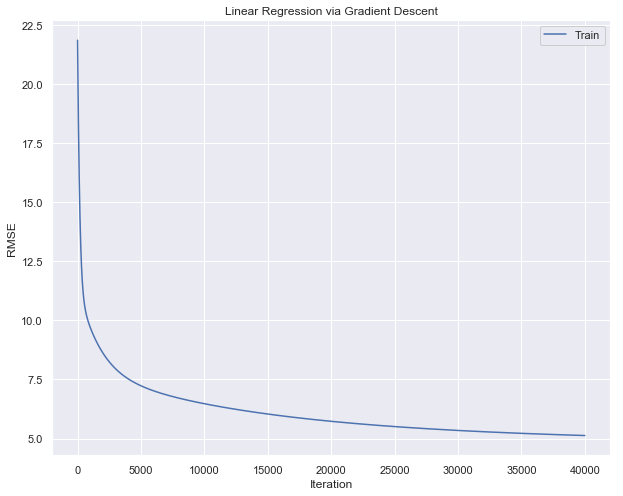

In [161]:
plt.figure(figsize=(10, 8))
plt.plot(model_homegrown.history["cost"], label="Train")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Linear Regression via Gradient Descent")
plt.legend();

## Evaluation

In [162]:
models = [model_sk, model_homegrown]
models_names = ["Sklearn", "Homegrown"]

In [163]:
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585
Homegrown Train,3.543379,5.127813,17.362884
Homegrown Test,3.378722,5.297880,18.182292


# Optional Assignment: Random Search

* Implement random search algorithm for Linear Regression as a child of **BasicLinearRegressionHomegrown** class. Then you need to reimplement only solution method (change GD to Random Search)
* Compare its performance with the previous implementations

Random search algorithm consists of the following steps:
1. Sample a set of weigths from some distribution. Here we're going to use Uniform distribution.
$$
\boldsymbol{\Theta} = \{\boldsymbol{\theta}_1, \boldsymbol{\theta}_2 \ldots \boldsymbol{\theta}_{N}\}
$$
2. Now we have a set of weights $\boldsymbol{\Theta}$ for Linear Regression. The idea is to choose the best one according to the objective.
$$
\boldsymbol{\theta^*} = \underset{\boldsymbol{\Theta}}{\text{argmin}} \sum_{i=1}^{n}\left[\boldsymbol{\theta} \cdot \mathbf{x_i} - y_i\right]^2
$$

In [164]:
class RandomSearchLinearRegressionHomegrown(BasicLinearRegressionHomegrown):
    
    def __init__(self):
        # call the constructor of the parent class
        super(RandomSearchLinearRegressionHomegrown, self).__init__()
        self.history = {"cost": [], 
                        "coef": [], 
                        "intercept": []}
        
    def _rs(self, X, y, max_iter):
        """
        Runs Random Search and logs error and weigths at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of points to sample
        Return:
            None
        """
        
        # use the following numpy command to generate
        # random sample from the weight space
        sampled_weights = np.random.random(size=(max_iter, len(self._theta))) * 20 - 10
        
        # go ahead and choose the best of sampled weights
        # according to the objective
        
        #==================================================#
        #               Place your code here               #
        #==================================================#
       
        # error for each theta
        # in this case error is a matrix with size [max_iter * number of examples]
        errors = np.dot(sampled_weights, X.T) - np.atleast_2d(y)
        # mse for each theta
        mses = np.mean((errors) ** 2, axis = 1)
        # best theta is the one with smallest error
        best_idx = np.argmin(mses)
        # get it!
        self._theta = sampled_weights[best_idx]
        
    
    def fit(self, X, y, max_iter=1000):
        """
        Public API for fitting a linear regression model

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of points to sample
        Return:
            self
        """
        X = np.c_[np.ones(X.shape[0]), X]
        if self._theta is None:
            self._theta = np.random.rand(X.shape[1])
        
        self._rs(X, y, max_iter)
        
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
        return self

Create model

In [165]:
model_homegrown_rs = RandomSearchLinearRegressionHomegrown()

Fitting

In [166]:
model_homegrown_rs.fit(X_train, y_train, max_iter=10000)

Evaluation

In [167]:
models = [model_sk, model_homegrown, model_homegrown_rs]
models_names = ["Sklearn", "Homegrown Full GD", "Homegrown RS"]

In [168]:
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585
Homegrown Full GD Train,3.543379,5.127813,17.362884
Homegrown Full GD Test,3.378722,5.297880,18.182292
Homegrown RS Train,6.645049,8.176139,34.831859
Homegrown RS Test,6.858416,8.786018,37.605292


# Optional Assignment: Numerical Calculation
* **BasicLinearRegressionHomegrown** class provides you with the method *_grad* that allows to compute analytical gradient. This function is correct
* Inheret from this class and implement a method for numerical approximation of gradient (see placeholder below)
* Check your function by comparing with the analytical one. They **should** be similar.
* Plot the difference of analytical and numerical gradients and describe what you observe

The formula for analytical gradient (from calculus):

$$
\nabla f(\mathbf{x}) = 
\begin{bmatrix}
\frac{\partial f}{\partial x_1}\\
\vdots\\
\frac{\partial f}{\partial x_m}
\end{bmatrix}, \text{ where } m \text{ is the space dimension}\\
\frac{\partial f}{\partial x_1} = \lim_{\alpha \rightarrow 0} \frac{f(x_1 + \alpha, x_2 \ldots x_m) - f(x_1, x_2 \ldots x_m)}{\alpha}
$$

For sufficiently small $\alpha$ one can approximate partial derivative by simple throwing out the limit operator

$$
\frac{\partial f}{\partial x_1} \approx \frac{f(x_1 + \alpha, x_2 \ldots x_m) - f(x_1, x_2 \ldots x_m)}{\alpha} = \left( \frac{\partial f}{\partial x_1} \right)_{\text{num}}\\
$$

Then the final approximation of the gradient is:

$$
\nabla f(\mathbf{x}) \approx \nabla_{\text{num}\,\,} f(\mathbf{x}) = \begin{bmatrix}
\left( \frac{\partial f}{\partial x_1} \right)_{\text{num}}\\
\vdots\\
\left( \frac{\partial f}{\partial x_m} \right)_{\text{num}}
\end{bmatrix}
$$

The common way of measuring the difference between vectors is the following:
$$
\text{er} = \frac{\|\nabla f(\mathbf{x}) - \nabla_{\text{num}\,\,}f(\mathbf{x})\|_2^2}{\|\nabla f(\mathbf{x})\|_2^2} = \frac{\sum_{j=1}^{m}\left(\nabla^j f(\mathbf{x}) - \nabla^j_{\text{num}\,\,}f(\mathbf{x})\right)^2}{\sum_{j=1}^{m}\left(\nabla^j f(\mathbf{x})\right)^2}
$$

In [169]:
class TweakedLinearRegressionHomegrown(BasicLinearRegressionHomegrown):
    
    def __init__(self):
        # call the constructor of the parent class
        super(TweakedLinearRegressionHomegrown, self).__init__()
        self.history["grad_num"] = []
        
    @staticmethod
    def _gradient_approximation(f, x):
        """
        Returns the numerical gradient of the function f at the point x

        Args:
            f(callable): function that takes the point x as an input 
                         and returns the value of the function
            x(ndarray): numpy array which contains the coordinates 
                        of the point to evaluate gradient
        Return:
            grad_num(ndarray): the numerical approximation 
                               of the gradient
        """

        grad_num = np.zeros(len(x))

        #==================================================#
        #               Place your code here               #
        #==================================================#

        alpha = 0.001
        for i in range(len(x)):
            h = np.zeros(len(x))
            h[i] += alpha
            grad_num[i] = (f(x + h) - f(x)) / alpha

        return grad_num
    
    
    def _grad_num(self, X, y):
        """
        Returns the numerical gradient of the LinearRegression 
        objective function

        Args:
            X(ndarray): train objects
            y(ndarray): answers for train objects
        Return:
            grad_num(ndarray): the numerical approximation 
                               of the gradient
        """
        
        grad_num = np.zeros(X.shape[1])
        
        #==================================================#
        #               Place your code here               #
        #         Use _gradient_approximation method       #
        #==================================================#
             
        def f(a):
            pred = np.dot(X, a)
            error = pred - y
            mse = np.mean(error ** 2)
            return mse
            
        
        grad_num = self._gradient_approximation(f, self._theta)
        
        return grad_num
        
        return grad_num
    
    def _gd(self, X, y, max_iter, alpha=0.001):
        """
        Runs GD and logs error, weigths, gradient and 
        numerical gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of EPOCHS, i.e., full passes over data
            batch_size(int): number of samples in one batch
            alpha(floar):    step size in direction of gradient
        Return:
            None
        """
        for i in range(max_iter):
            self.history["coef"].append(self._theta[1:].copy())
            self.history["intercept"].append(self._theta[0].copy())
            
            rmse = self.score(X, y)
            self.history["cost"].append(rmse)

            grad = self._grad(X, y)
            self.history["grad"].append(grad)
            
            grad_num = self._grad_num(X, y)
            self.history["grad_num"].append(grad_num)
            
            self._theta -= alpha * grad

Create model

In [170]:
model_homegrown_check_grad = TweakedLinearRegressionHomegrown()

Fitting

In [171]:
model_homegrown_check_grad.fit(X_train, y_train, max_iter=40000)

Plotting error curves

In [172]:
def relative_error(grad, grad_num):
    return np.sum((grad - grad_num) ** 2, axis=1) * 1. / np.sum(grad ** 2, axis=1)

In [173]:
def absolute_error(grad, grad_num):
    return np.sum((grad - grad_num) ** 2, axis=1) * 1.

In [174]:
grad_num = np.array(model_homegrown_check_grad.history["grad_num"])
grad = np.array(model_homegrown_check_grad.history["grad"])

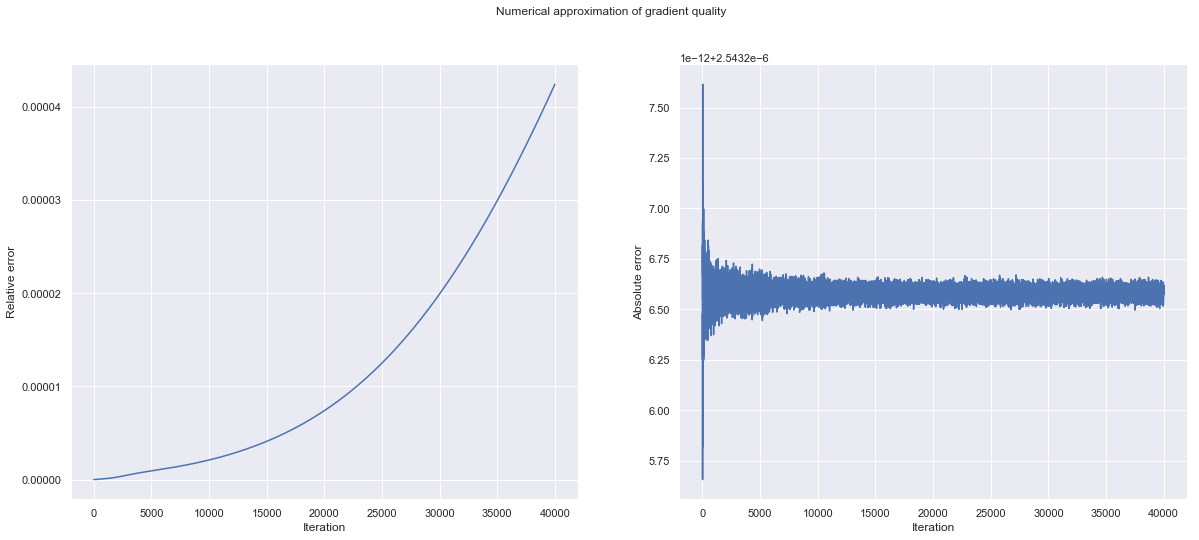

In [175]:
plt.figure(figsize=(20, 8))
plt.suptitle("Numerical approximation of gradient quality")
plt.subplot(121)
plt.plot(relative_error(grad, grad_num))
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.subplot(122)
plt.plot(absolute_error(grad, grad_num))
plt.xlabel("Iteration")
plt.ylabel("Absolute error")
plt.show()

# Optional Assignment: Stochastic Gradient Descent
* Implement stochastic gradient descent algorithm as a member of a class
* Check that analytical gradient is right via numerical gradient function from **TweakedLinearRegressionHomegrown**

In Full GD we do a descent step only after the calculation of the gradient over the whole set of data. In this case the gradient is precise and gives the best possible direction. But it can require quite a lot of time if we have huge amounts of data. 

In practice we can get faster convergence if we calculate the gradient not over the whole set of data but over the small (size of $B$) **batch** of it.

$$
\nabla f(\boldsymbol{\theta}) \approx \nabla_{\text{batch}\,\,} f(\boldsymbol{\theta}) = \frac{2}{n}\sum_{i=1}^{B}\left(\mathbf{x}'_{a_i}\cdot \boldsymbol{\theta} - y_{a_i}\right)\cdot \mathbf{x}'_{a_i}
$$
where $a_i$ is an array of indices of objects which are in this batch. Common approach here that you should use is to shuffle samples randomly and then iterate over them with batches.

So with this batch approach we get an approximation of the real gradient in point $\boldsymbol{\theta}$. This approximation is very cheap and fast to compute (usually $B$ is not too big $-$ from 32 to 256). After obtaining this gradient we do a descent step in this approximate direction and proceed to the next stage of batch descent.

In [176]:
class StochasticLinearRegressionHomegrown(TweakedLinearRegressionHomegrown):
    
    def __init__(self):
        # call the constructor of the parent class
        super(StochasticLinearRegressionHomegrown, self).__init__()
        self.history["grad_num"] = []
    
    def _sgd(self, X, y, max_iter, batch_size, alpha=0.0005):
        """
        Runs Stochastic GD and logs error, weigths, gradient and 
        numerical gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of EPOCHS, i.e., full passes over data
            batch_size(int): number of samples in one batch
            alpha(floar):    step size in direction of gradient
        Return:
            None
        """
        
        #==================================================#
        #               Place your code here               #
        #==================================================#
        
        for epoch in range(max_iter):
            idxs = np.random.permutation(X.shape[0])
            X = X[idxs]
            y = y[idxs]
            for i in range(0, len(X), batch_size):
                
                self.history["coef"].append(self._theta[1:].copy())
                self.history["intercept"].append(self._theta[0].copy())
                
                rmse = self.score(X, y)
                self.history["cost"].append(rmse)
                
                # calculate gradient
                grad = self._grad(X[i:i + batch_size], y[i:i + batch_size])
                self.history["grad"].append(grad)
                
                # numerical gradient
                grad_num = self._grad_num(X[i:i + batch_size], y[i:i + batch_size])
                self.history["grad_num"].append(grad_num)
            
                # do gradient step
                self._theta -= alpha * grad
        
        
    def fit(self, X, y, max_iter=1000, batch_size=16):
        """
        Public API for fitting a linear regression model

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of EPOCHS, i.e., full passes over data
            batch_size(int): number of samples in one batch
        Return:
            self
        """
        X = np.c_[np.ones(X.shape[0]), X]
        if self._theta is None:
            self._theta = np.random.rand(X.shape[1])

        self._sgd(X, y, max_iter, batch_size)
        
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
        return self

Create model

In [177]:
model_homegrown_sgd = StochasticLinearRegressionHomegrown()

Fitting

In [178]:
model_homegrown_sgd.fit(X_train, y_train, max_iter=1500)

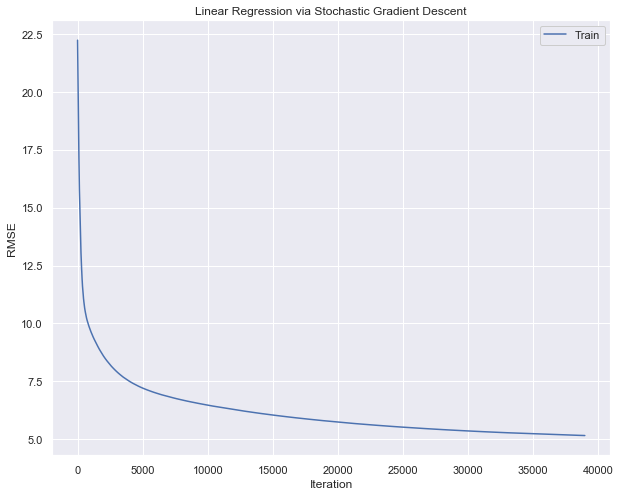

In [179]:
plt.figure(figsize=(10, 8))
plt.plot(model_homegrown_sgd.history["cost"], label="Train")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Linear Regression via Stochastic Gradient Descent")
plt.legend(frameon=True)
plt.show()

Evaluation

In [180]:
models = [model_sk, model_homegrown, model_homegrown_sgd]
models_names = ["Sklearn", "Homegrown Full GD", "Homegrown SGD"]

In [181]:
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585
Homegrown Full GD Train,3.543379,5.127813,17.362884
Homegrown Full GD Test,3.378722,5.297880,18.182292
Homegrown SGD Train,3.584664,5.164762,17.592241
Homegrown SGD Test,3.389541,5.301505,18.269340


## L1 and L2 regularization from scratch
Incorporate L1 and L2 regularization for the BasicLinearRegressionHomegrown class developed above.  Start with L2 regularization.

In [182]:
class RegularizedLinearRegressionHomegrown(BasicLinearRegressionHomegrown):
    
    def __init__(self, l1_reg=0.0, l2_reg=0.0):
        # call the constructor of the parent class
        super(RegularizedLinearRegressionHomegrown, self).__init__()
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        
    def _grad(self, X, y):
        """
        Calculate the gradient of the objective function 
        with L1 and L2 regularizations

        Args:
            X(ndarray):        train objects
            y(ndarray):        answers for train objects
        Return:
            gradient(ndarray): analytical gradient vector
        """
        pred = np.dot(X, self._theta)
        error = pred - y
        gradient = 2 * np.dot(error, X) / X.shape[0]
        # penalties only for weights
        gradient[1:] += 2 * self.l2_reg * self._theta[1:] + self.l1_reg * np.sign(self._theta[1:])
        return gradient

In [183]:
model_homegrown_regularized_l2 = RegularizedLinearRegressionHomegrown(l1_reg=0.0, l2_reg=0.1)
model_homegrown_regularized_l1 = RegularizedLinearRegressionHomegrown(l1_reg=1.0, l2_reg=0.0)

In [184]:
model_homegrown_regularized_l2.fit(X_train, y_train, max_iter=40000)
model_homegrown_regularized_l1.fit(X_train, y_train, max_iter=40000)

In [185]:
models = [model_sk, model_homegrown, model_homegrown_regularized_l2, model_homegrown_regularized_l1]
models_names = ["Sklearn", "Homegrown", "Homegrown Regularized L2", "Homegrown Regularized L1"]

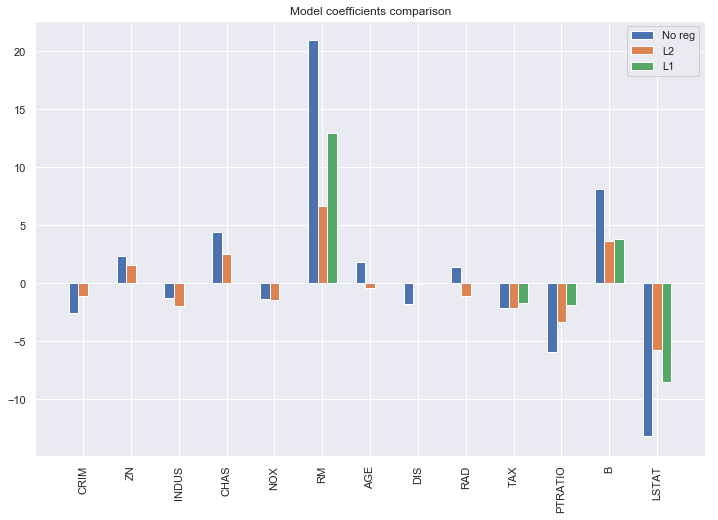

In [186]:
plt.figure(figsize=(12, 8))
plt.bar(np.arange(model_homegrown.coef_.shape[0]) - 0.2, model_homegrown.coef_, width=0.2, label="No reg")
plt.bar(np.arange(model_homegrown_regularized_l2.coef_.shape[0]), model_homegrown_regularized_l2.coef_, width=0.2, label="L2")
plt.bar(np.arange(model_homegrown_regularized_l1.coef_.shape[0]) + 0.2, model_homegrown_regularized_l1.coef_, width=0.2, label="L1")
plt.xticks(np.arange(model_sk.coef_.shape[0]), X.columns, rotation='vertical')
plt.xlim([-1, model_sk.coef_.shape[0]])
plt.title("Model coefficients comparison")
plt.legend();

In [187]:
print("2-norm of weights:\n")
print("{:10s}{:.2f}".format("No reg:", np.linalg.norm(model_homegrown.coef_)))
print("{:10s}{:.2f}".format("L2:", np.linalg.norm(model_homegrown_regularized_l2.coef_)))
print("{:10s}{:.2f}".format("L1:", np.linalg.norm(model_homegrown_regularized_l1.coef_)))

2-norm of weights:

No reg:   27.56
L2:       11.12
L1:       16.16


In [188]:
print("Number of non-zero coefficients:\n")
print("{:10s}{:d}".format("No reg:", np.sum(np.abs(model_homegrown.coef_) > 1e-2)))
print("{:10s}{:d}".format("L2:", np.sum(np.abs(model_homegrown_regularized_l2.coef_) > 1e-2)))
print("{:10s}{:d}".format("L1:", np.sum(np.abs(model_homegrown_regularized_l1.coef_) > 1e-2)))

Number of non-zero coefficients:

No reg:   13
L2:       13
L1:       5


# Optional Assignment: Adaptive step size [no bonus points for this question]

## Line Search of the step size
Instead of doing a gradient step with the fixed step size ($\alpha=0.0005$) consider it as a variable after choosing the step directon (gradient one) and try to optimize it. In other words solve analyticaly the following 1D optimization problem:

$$
f\left(\boldsymbol{\theta}_{t} - \alpha \cdot \nabla f(\boldsymbol{\theta}_{t})\right) \rightarrow \min_{\alpha}
$$



## Modify your GD model to use adaptive step size
* What happens?
* How does it influence the time in terms of number of iterations?

In [189]:
class OptimalStepBasicLinearRegressionHomegrown(BasicLinearRegressionHomegrown):
       
    def __init__(self):
        super(OptimalStepBasicLinearRegressionHomegrown, self).__init__()
        self.history["alpha"] = []
        
    def _gd(self, X, y, max_iter):
        """
        Runs GD and logs error, weigths, gradient at every step.
        Here the optimal step size used with formulas from above.

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
        Return:
            None
        """
        
        for i in range(max_iter):
            
            self.history["coef"].append(self._theta[1:].copy())
            self.history["intercept"].append(self._theta[0].copy())
            
            rmse = self.score(X, y)
            self.history["cost"].append(rmse)

            # calculate gradient
            grad = self._grad(X, y)
            self.history["grad"].append(grad)
            
            # optimum step size
        
            #==================================================#
            #               Place your code here               #
            #==================================================#
            alpha = X.shape[0] / 2. * (np.linalg.norm(grad) / np.linalg.norm(X.dot(grad))) ** 2
            self.history["alpha"] = alpha
            
            # do gradient step
            self._theta -= alpha * grad

In [190]:
model_homegrown_optimal_step = OptimalStepBasicLinearRegressionHomegrown()

In [191]:
model_homegrown_optimal_step.fit(X_train, y_train, max_iter=40000)

In [192]:
models = [model_sk, model_homegrown, model_homegrown_optimal_step]
models_names = ["Sklearn", "Homegrown", "Homegrown with Optimal step size"]

In [193]:
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585
Homegrown Train,3.543379,5.127813,17.362884
Homegrown Test,3.378722,5.297880,18.182292
Homegrown with Optimal step size Train,3.315165,4.652051,16.573489
Homegrown with Optimal step size Test,3.191509,4.930662,16.880585


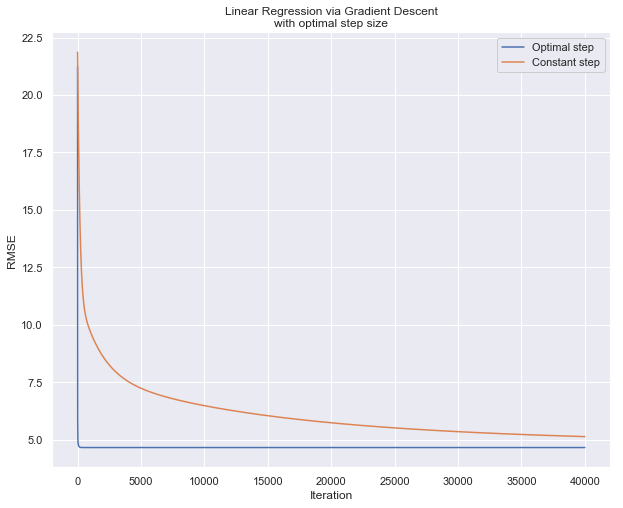

In [194]:
plt.figure(figsize=(10, 8))
plt.plot(model_homegrown_optimal_step.history["cost"], label="Optimal step")
plt.plot(model_homegrown.history["cost"], label="Constant step")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Linear Regression via Gradient Descent\nwith optimal step size")
plt.legend(frameon=True);